<a href="https://colab.research.google.com/github/dbos23/Predicting_Hospital_Readmission/blob/main/Thinkful_Final_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this project, I'll be using machine learning and deep learning techniques to classify diabetic hospital patients into those that will and won't be readmitted. This model would be useful for hospitals looking to anticipate and address the needs of their patients. A patient projected to be readmitted could be informed of their risk and proper steps (such as follow-up appointments and medical treatments) could be used to head off any future issues.

I found the dataset from the UCI Machine Learning Repository here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

The original paper that used the data can be found here: https://www.hindawi.com/journals/bmri/2014/781670/

Detailed information about each variable can be found here:
https://www.hindawi.com/journals/bmri/2014/781670/tab1/

The dataset contains data from 130 U.S. hospitals from the years 1999-2008. All the patients in the dataset satisfied the following criteria:
1. They were admitted to the hospital (inpatient).
2. The patient was diabetic.
3. The duration of the patient's stay was 1-14 days.
4. Laboratory tests were performed.
5. Medications were administered.

The variables are as follows:
- encounter_id: unique identifier of an encounter
- patient_nbr: unique identifier of a patient
- race: patient's race
- gender: patient's gender
- age: grouped in 10 year intervals
- weight: in pounds, grouped in intervals
- admission_type_id: number corresponding to type of admission (ex: emergency)
- discharge_disposition_id: number corresponding to the conditions of the patient's discharge (ex: discharged to home)
- admission_source_id: number corresponding to how the patient came to be admitted (ex: physician referral)
- time_in_hospital: length of stay in days
- payer_code: number corresponding to type of payment (ex: self-pay, Medicare)
- medical_specialty: specialty of the admitting physician
- num_lab_procedures: number of lab tests performed
- num_procedures: number of procedures performed (excluding lab tests)
- num_medications: number of distinct medications administered
- number_outpatient: number of outpatient visits of the patient in the preceding year
- number_emergency: number of emergency visits of the patient in the preceding year
- number_inpatient: number of inpatient visits of the patient in the preceding year
- diag_1: primary diagnosis (as first 3 digits of ICD9 code)
- diag_2: secondary diagnosis (as first 3 digits of ICD9 code)
- diag_3: additional secondary diagnosis (as first 3 digits of ICD9 code)
- number_diagnoses: number of diagnoses entered
- max_glu_serum: glucose serum test result
- A1Cresult: A1C test result
- change: whether or not the patient's diabetes medication (either dosage or medicine type) was changed during the visit
- diabetesMed: whether or not the patient was prescribed diabetes medication
- readmitted: target variable; whether patient was readmitted within 30 days, readmitted at a later time, or wasn't readmitted

The rest of the variables correspond to 24 different medications and have 4 possible values: up (dosage increased), down (dosage lowered), steady (dosage unchanged), no (medication not prescribed)

# Data Cleaning - Missing Values

In [ ]:
!pip install kmodes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/diabetic_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

There are no obvious missing values but admission_type_id, discharge_disposition_id, and admission_source_id are all listed as numbers that are shorthand for a description of the circumstances surrounding the type of admission (ex: emergency), how they were discharged (ex: discharged to home), and how they came to be admitted (ex: physician referral). There are too many values to list here but the descriptions of all of these ID numbers can be found in a document at the above link. For the data cleaning process, it's important to note that these variables have numbers corresponding to the values 'NULL,' 'not mapped,' 'not available,' and 'unknown/invalid.' These all seem to be missing values and they will need to be addressed.

In [ ]:
n_1 = df[df['admission_type_id']==5]['admission_type_id'].count() #counting 'not available' values
n_2 = df[df['admission_type_id']==6]['admission_type_id'].count() #counting 'NULL' values
n_3 = df[df['admission_type_id']==8]['admission_type_id'].count() #counting 'not mapped' values

print(f'Missing values from admission_type_id: {n_1+n_2+n_3}')

Missing values from admission_type_id: 10396


In [ ]:
n_1 = df[df['discharge_disposition_id']==18]['discharge_disposition_id'].count() #counting 'NULL' values
n_2 = df[df['discharge_disposition_id']==25]['discharge_disposition_id'].count() #counting 'not mapped' values
n_3 = df[df['discharge_disposition_id']==26]['discharge_disposition_id'].count() #counting 'unknown/invalid' values

print(f'Missing values from discharge_disposition_id: {n_1+n_2+n_3}')

Missing values from discharge_disposition_id: 4680


In [ ]:
n_1 = df[df['admission_source_id']==9]['admission_source_id'].count() #counting 'not available' values
n_2 = df[df['admission_source_id']==15]['admission_source_id'].count() #counting 'not available' values (there are two 'not available' values for this variable)
n_3 = df[df['admission_source_id']==17]['admission_source_id'].count() #counting 'NULL' values
n_4 = df[df['admission_source_id']==20]['admission_source_id'].count() #counting 'not mapped' values
n_5 = df[df['admission_source_id']==21]['admission_source_id'].count() #counting 'unknown/invalid' values

print(f'Missing values for admission_source_id: {n_1+n_2+n_3+n_4+n_5}')

Missing values for admission_source_id: 7067


Overall, there are 10,396 missing values for admission_type_id, 4,680 missing values for discharge_disposition_id, and 7,067 missing values for admission_source_id. Rather than discard all these data points, I'll instead map each of the missing values to the same number, which will represent the category of all the missing values for that variable. This will allow me to proceed with creating this model without losing a lot of potentially helpful data.

In [ ]:
df.loc[df['admission_type_id'] == 6, 'admission_type_id'] = 5
df.loc[df['admission_type_id'] == 8, 'admission_type_id'] = 5

df.loc[df['discharge_disposition_id'] == 25, 'discharge_disposition_id'] = 18
df.loc[df['discharge_disposition_id'] == 26, 'discharge_disposition_id'] = 18

df.loc[df['admission_source_id'] == 15, 'admission_source_id'] = 9
df.loc[df['admission_source_id'] == 17, 'admission_source_id'] = 9
df.loc[df['admission_source_id'] == 20, 'admission_source_id'] = 9
df.loc[df['admission_source_id'] == 21, 'admission_source_id'] = 9

Now I'll start looking for missing values in the other variables that are disguised as something other than np.nan. I can skip some of the variables. encounter_id is a unique identifier for each encounter, which won't be useful for the classification task. patient_nbr is a number that corresponds to each patient. I'll drop both of these from the dataframe.

In [ ]:
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

Now I'll search for other missing values. There are a lot of variables in this dataframe so in the interest of better organizing this notebook, I'll address one set of variables at a time. For this first section, I'll look at:
- race
- gender
- age
- weight
- time_in_hospital
- payer_code
- medical_specialty
- num_lab_procedures
- num_procedures
- num_medications

In [ ]:
df['race'].unique()

array(['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [ ]:
df[df['race'] == '?']['race'].count()

2273

In [ ]:
df['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [ ]:
df[df['gender'] == 'Unknown/Invalid']['gender'].count()

3

In [ ]:
df['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [ ]:
df['weight'].unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [ ]:
df[df['weight'] == '?']['weight'].count()

98569

In [ ]:
df['time_in_hospital'].unique()

array([ 1,  3,  2,  4,  5, 13, 12,  9,  7, 10,  6, 11,  8, 14])

In [ ]:
df['payer_code'].unique()

array(['?', 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [ ]:
df[df['payer_code'] == '?']['payer_code'].count()

40256

In [ ]:
df['medical_specialty'].unique()

array(['Pediatrics-Endocrinology', '?', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

In [ ]:
df[df['medical_specialty']=='?']['medical_specialty'].count()

49949

In [ ]:
df['num_lab_procedures'].unique()

array([ 41,  59,  11,  44,  51,  31,  70,  73,  68,  33,  47,  62,  60,
        55,  49,  75,  45,  29,  35,  42,  66,  36,  19,  64,  25,  53,
        52,  87,  27,  37,  46,  28,  48,  72,  10,   2,  65,  67,  40,
        54,  58,  57,  43,  32,  83,  34,  39,  69,  38,  56,  22,  96,
        78,  61,  88,  50,   1,  18,  82,   9,  63,  24,  71,  77,  81,
        76,  90,  93,   3, 103,  13,  80,  85,  16,  15,  12,  30,  23,
        17,  21,  79,  26,   5,  95,  97,  84,  14,  74, 105,  86,  98,
        20,   6,  94,   8, 102, 100,   7,  89,  91,  92,   4, 101,  99,
       114, 113, 111, 129, 107, 108, 106, 104, 109, 120, 132, 121, 126,
       118])

In [ ]:
df['num_procedures'].unique()

array([0, 5, 1, 6, 2, 3, 4])

In [ ]:
df['num_medications'].unique()

array([ 1, 18, 13, 16,  8, 21, 12, 28, 17, 11, 15, 31,  2, 23, 19,  7, 20,
       14, 10, 22,  9, 27, 25,  4, 32,  6, 30, 26, 24, 33,  5, 39,  3, 29,
       61, 40, 46, 41, 36, 34, 35, 50, 43, 42, 37, 51, 38, 45, 54, 52, 49,
       62, 55, 47, 44, 53, 48, 57, 59, 56, 60, 63, 58, 70, 67, 64, 69, 65,
       68, 66, 81, 79, 75, 72, 74])

The missing values are as follows:
- race (2,273 entered as ?)
- gender (3 entered as Unknown/Invalid)
- weight (98,569 entered as ?)
- payer_code (40,256 entered as ?)
- medical_specialty (49,949 entered as ?)

There are so few missing values for gender that those data points can be dropped with almost no impact to the dataframe. There are so many missing values for weight, payer_code, and medical_specialty that the columns don't provide enough information to be useful so I'll drop them.

In [ ]:
df = df[df['gender'] != 'Unknown/Invalid']
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

For race, I'll leave the values of ? as they are. They'll serve as another category of unknown values. This will allow me to keep the information form the other columns of those data points.

The next batch of variables I'll look at is:
- number_outpatient
- number_emergency
- number_inpatient
- diag_1
- diag_2
- diag_3
- number_diagnoses
- max_glu_serum
- A1Cresult
- change
- diabetesMed
- readmitted

In [ ]:
df['number_outpatient'].unique()

array([ 0,  2,  1,  5,  7,  9,  3,  8,  4, 12, 11,  6, 20, 15, 10, 13, 14,
       16, 21, 35, 17, 29, 36, 18, 19, 27, 22, 24, 42, 39, 34, 26, 33, 25,
       23, 28, 37, 38, 40])

In [ ]:
df['number_emergency'].unique()

array([ 0,  1,  2,  4,  3,  9,  5,  7,  6,  8, 22, 25, 10, 13, 42, 16, 11,
       28, 15, 14, 18, 12, 21, 20, 19, 46, 76, 37, 64, 63, 54, 24, 29])

In [ ]:
df['number_inpatient'].unique()

array([ 0,  1,  2,  3,  6,  5,  4,  7,  8,  9, 15, 10, 11, 14, 12, 13, 17,
       16, 21, 18, 19])

In [ ]:
df['diag_1'].unique()

array(['250.83', '276', '648', '8', '197', '414', '428', '398', '434',
       '250.7', '157', '518', '999', '410', '682', '402', '737', '572',
       'V57', '189', '786', '427', '996', '277', '584', '462', '473',
       '411', '174', '486', '998', '511', '432', '626', '295', '196',
       '250.6', '618', '182', '845', '423', '808', '250.4', '722', '403',
       '250.11', '784', '707', '440', '151', '715', '997', '198', '564',
       '812', '38', '590', '556', '578', '250.32', '433', 'V58', '569',
       '185', '536', '255', '250.13', '599', '558', '574', '491', '560',
       '244', '250.03', '577', '730', '188', '824', '250.8', '332', '562',
       '291', '296', '510', '401', '263', '438', '70', '250.02', '493',
       '642', '625', '571', '738', '593', '250.42', '807', '456', '446',
       '575', '250.41', '820', '515', '780', '250.22', '995', '235',
       '250.82', '721', '787', '162', '724', '282', '514', 'V55', '281',
       '250.33', '530', '466', '435', '250.12', 'V53', '789', '

In [ ]:
df[df['diag_1'] == '?']['diag_1'].count()

21

In [ ]:
df['diag_2'].unique()

array(['?', '250.01', '250', '250.43', '157', '411', '492', '427', '198',
       '403', '288', '998', '507', '174', '425', '456', '401', '715',
       '496', '428', '585', '250.02', '410', '999', '996', '135', '244',
       '41', '571', '276', '997', '599', '424', '491', '553', '707',
       '286', '440', '493', '242', '70', 'V45', '250.03', '357', '511',
       '196', '396', '197', '414', '250.52', '577', '535', '413', '285',
       '53', '780', '518', '150', '566', '250.6', '867', '486', 'V15',
       '8', '788', '340', '574', '581', '228', '530', '250.82', '786',
       '294', '567', '785', '512', '305', '729', '250.51', '280', '648',
       '560', '618', '444', '38', 'V10', '578', '277', '781', '250.42',
       '278', '426', '584', '462', '402', '153', '272', '733', '34',
       '881', '203', '250.41', '250.13', '293', '245', '250.12', '558',
       '787', '342', '573', '626', '303', '250.53', '458', '710', '415',
       'V42', '284', '569', '759', '682', '112', '292', '435', '290'

In [ ]:
df[df['diag_2'] == '?']['diag_2'].count()

358

In [ ]:
df[df['diag_3'] == '?']['diag_3'].count()

1423

In [ ]:
df['number_diagnoses'].unique()

array([ 1,  9,  6,  7,  5,  8,  3,  4,  2, 16, 12, 13, 15, 10, 11, 14])

In [ ]:
df['max_glu_serum'].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

In [ ]:
df[df['max_glu_serum'] == 'None']['max_glu_serum'].count()

96417

In [ ]:
df['A1Cresult'].unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [ ]:
df[df['A1Cresult'] == 'None']['A1Cresult'].count()

84745

In [ ]:
df['change'].unique()

array(['No', 'Ch'], dtype=object)

In [ ]:
df['diabetesMed'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

Here are the missing values for this set of variables:
- diag_1 (21 entered as ?)
- diag_2 (358 entered as ?)
- diag_3 (1423 entered as ?)

There are also 96,417 values of max_glu_serum entered as None and 84,745 values of A1Cresult entered as None. I would argue that those variables aren't truly missing. Per the documentation for this dataset, this indicates that the test in question wasn't performed. This is still information rather than the absence of information. For diag_1, diag_2, and diag_3, I'll drop the missing values, as they represent only a small percentage of the dataset so this won't have too much of a negative effect.

In [ ]:
df = df[df['diag_1'] != '?']
df = df[df['diag_2'] != '?']
df = df[df['diag_3'] != '?']

The rest of the variables - from metformin to metformin-pioglitazone - are all medications. The documentation for the dataset lists all possible values for each of these variables:
- up (dosage increased during admission)
- down (dosage decreased)
- steady (dosage unchanged)
- no (drug was not prescribed)

This saves me the trouble of examining each variable individually.

# Data Cleaning - Outliers

Next I'll start by looking for outliers. The following are the continuous variables:
- time_in_hospital
- num_lab_procedures
- num_procedures
- num_medications
- number_outpatient
- number_emergency
- number_inpatient
- number_diagnoses

The rest are all categorical. I'll use boxplots to check for outliers in all the continuous variables.

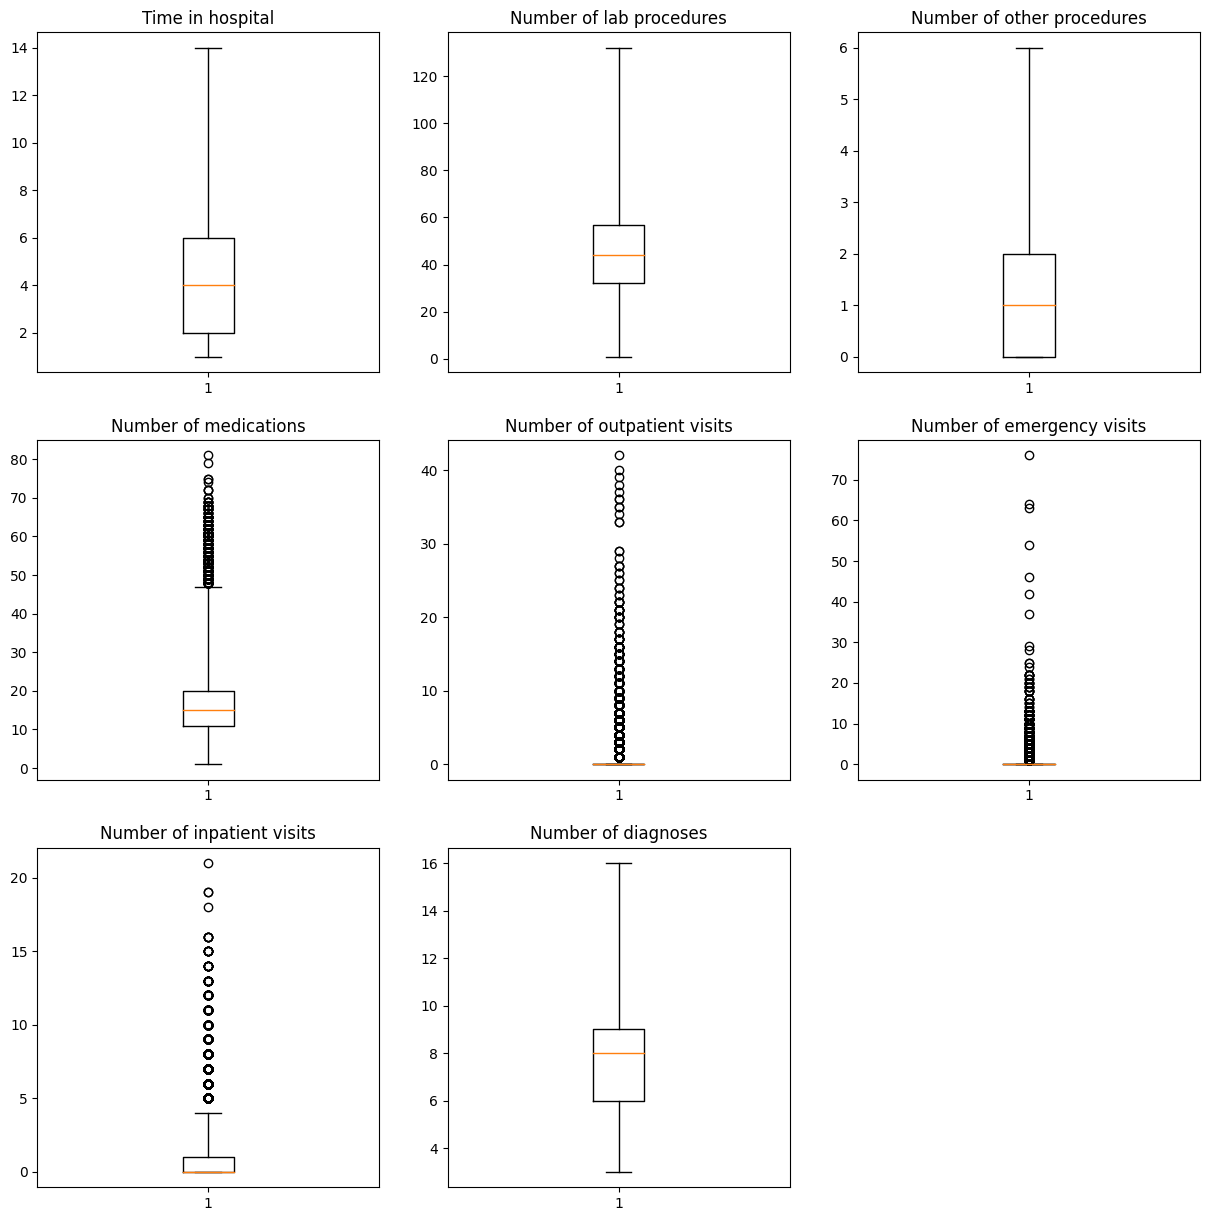

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1)
plt.title('Time in hospital')
plt.boxplot(df['time_in_hospital'], whis=3)

plt.subplot(3, 3, 2)
plt.title('Number of lab procedures')
plt.boxplot(df['num_lab_procedures'], whis=3)

plt.subplot(3, 3, 3)
plt.title('Number of other procedures')
plt.boxplot(df['num_procedures'], whis=3)

plt.subplot(3, 3, 4)
plt.title('Number of medications')
plt.boxplot(df['num_medications'], whis=3)

plt.subplot(3, 3, 5)
plt.title('Number of outpatient visits')
plt.boxplot(df['number_outpatient'], whis=3)

plt.subplot(3, 3, 6)
plt.title('Number of emergency visits')
plt.boxplot(df['number_emergency'], whis=3)

plt.subplot(3, 3, 7)
plt.title('Number of inpatient visits')
plt.boxplot(df['number_inpatient'], whis=3)

plt.subplot(3, 3, 8)
plt.title('Number of diagnoses')
plt.boxplot(df['number_diagnoses'], whis=3)

plt.show()

There are outliers for the following:
- num_medications
- number_outpatient
- number_emergency
- number_inpatient

I'll try to take the log transformation of num_medications and see if that takes care of the outliers. I can't use the log for the other variables because there are values of 0 for those.

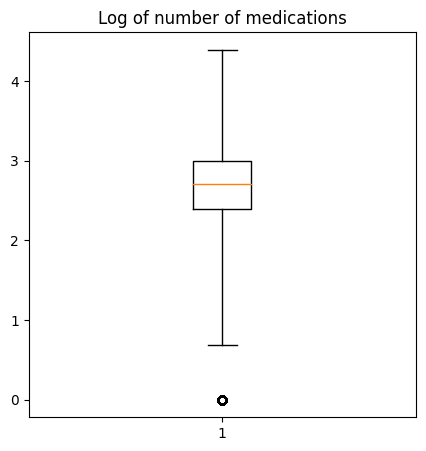

In [ ]:
plt.figure(figsize=(5,5))

plt.title('Log of number of medications')
plt.boxplot(np.log(df['num_medications']), whis=3)

plt.show()

There's still an outlier so I'll try using winsorization on all four variables with outliers.

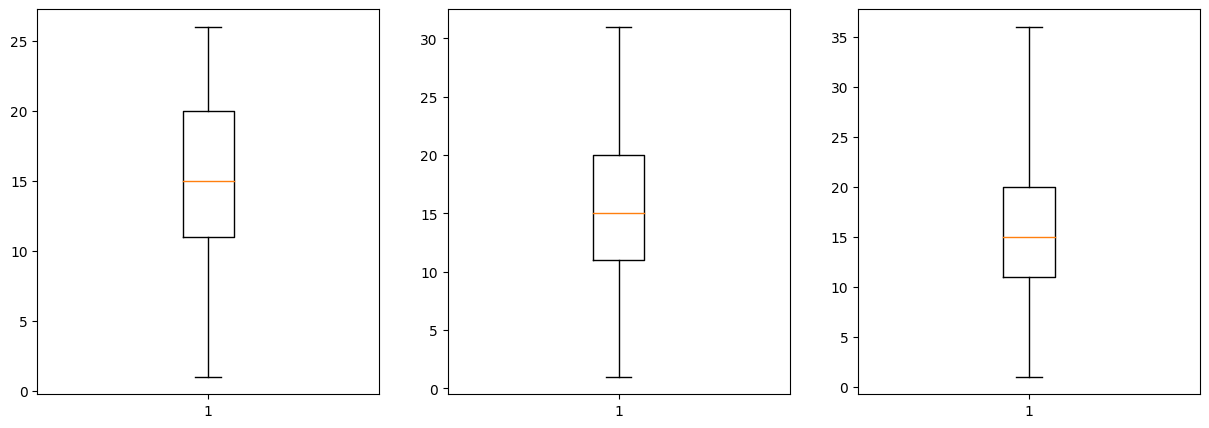

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .1)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .05)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .025)), whis=3)

plt.show()

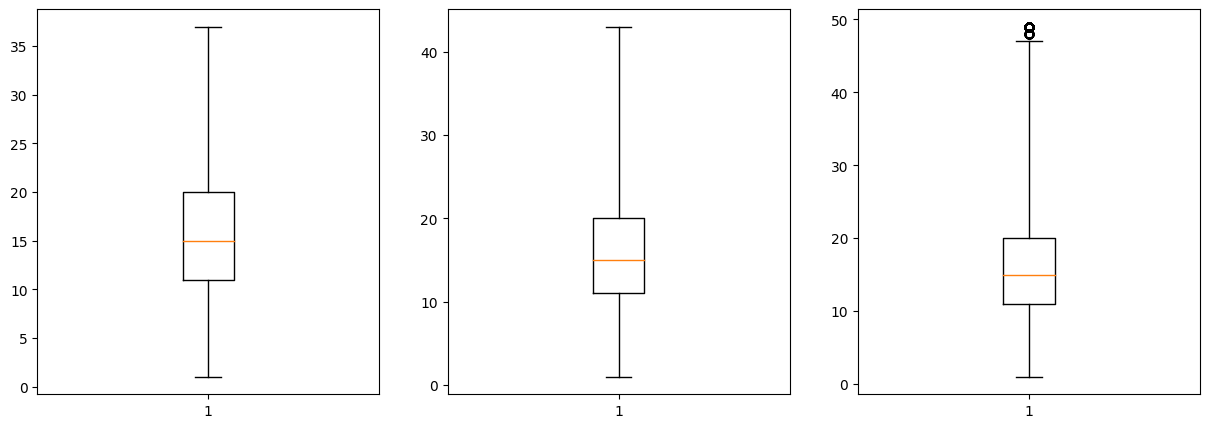

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .02)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .01)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .005)), whis=3)

plt.show()

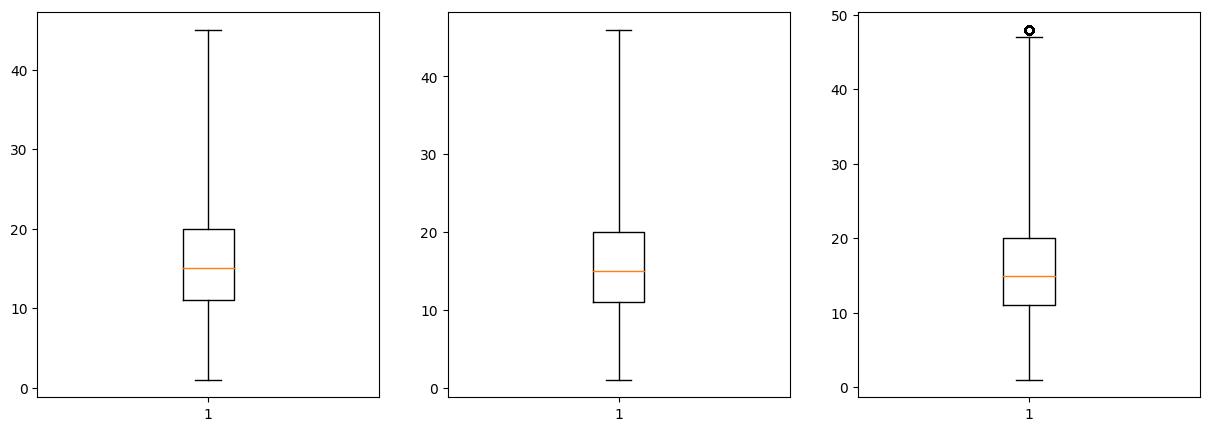

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .008)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .007)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['num_medications'], (0, .006)), whis=3)

plt.show()

In [ ]:
df['winsorized_num_medications'] = stats.mstats.winsorize(df['num_medications'], (0, .006))
df.drop('num_medications', axis=1, inplace=True)

.006 is the right value to winsorize the outliers without interfering with other values.

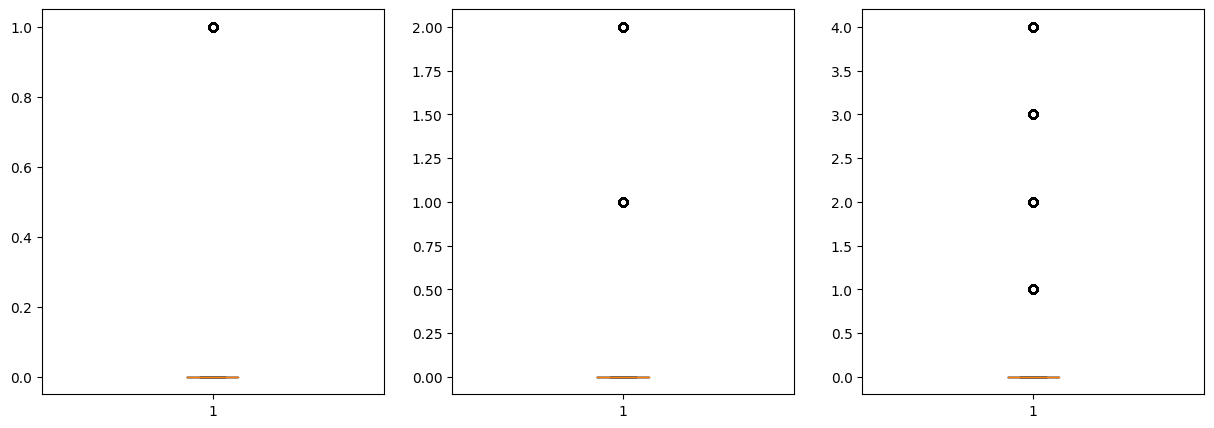

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['number_outpatient'], (0, .1)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['number_outpatient'], (0, .05)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['number_outpatient'], (0, .025)), whis=3)

plt.show()

In [ ]:
df['number_outpatient'].describe()

count    100241.000000
mean          0.372572
std           1.274092
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: number_outpatient, dtype: float64

In [ ]:
df[df['number_outpatient'] == 0]['number_outpatient'].count()

83629

This variable is extremely skewed. Over 80% of the entries have a value of 0 and yet the max is 42. Winsorizing the outliers would result in a column with every value equal to 0 (which would be useless) but keeping the outliers would allow a few datapoints to have a disproportionately high influence on the model. I think the best thing to do is to drop this column from the dataframe.

In [ ]:
df.drop('number_outpatient', axis=1, inplace=True)

I'll take a look at number_emergency and number_inpatient but it seems like number_emergency may have the same problem.

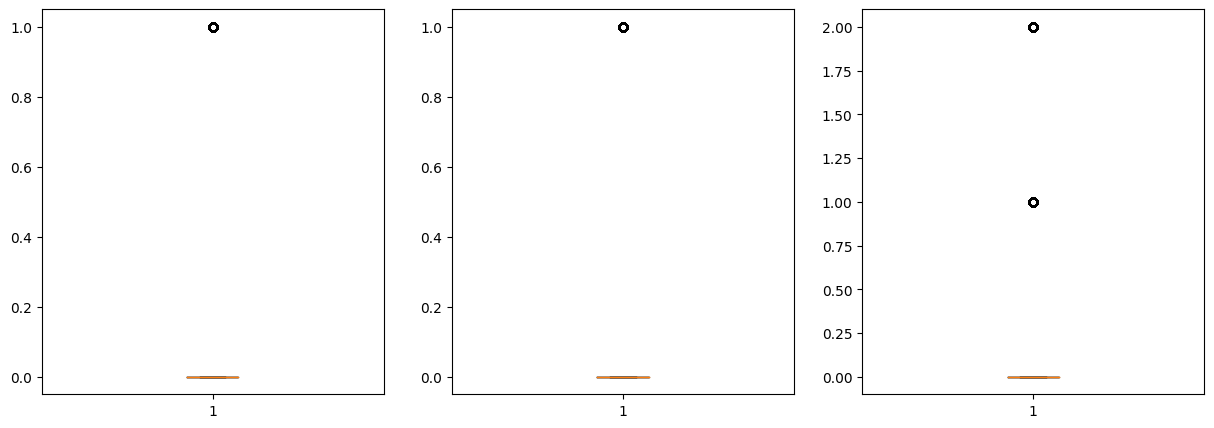

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['number_emergency'], (0, .1)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['number_emergency'], (0, .05)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['number_emergency'], (0, .025)), whis=3)

plt.show()

In [ ]:
df['number_emergency'].describe()

count    100241.000000
mean          0.199020
std           0.933554
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          76.000000
Name: number_emergency, dtype: float64

In [ ]:
df[df['number_emergency'] == 0]['number_emergency'].count()

88955

Sure enough, number_emergency has the same issue so I'll drop that column too.

In [ ]:
df.drop('number_emergency', axis=1, inplace=True)

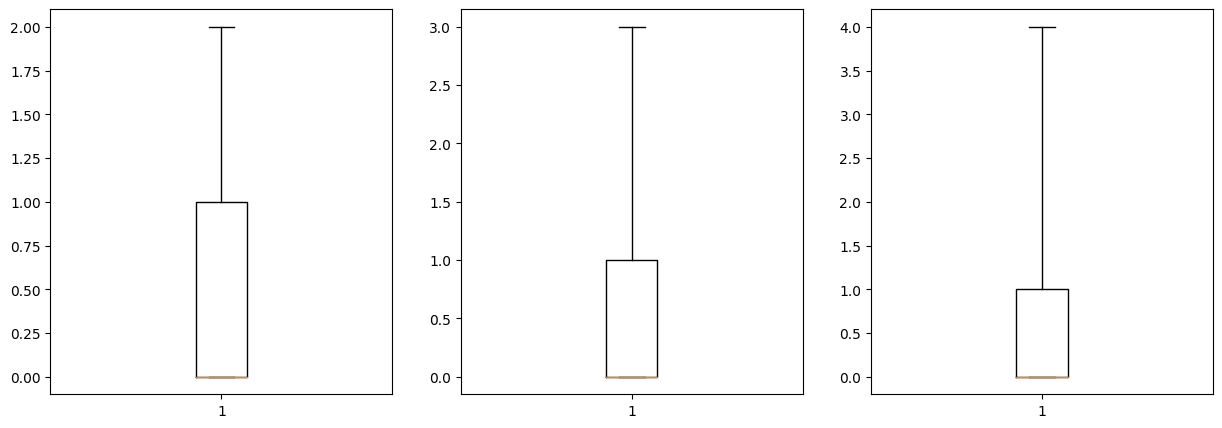

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .1)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .05)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .025)), whis=3)

plt.show()

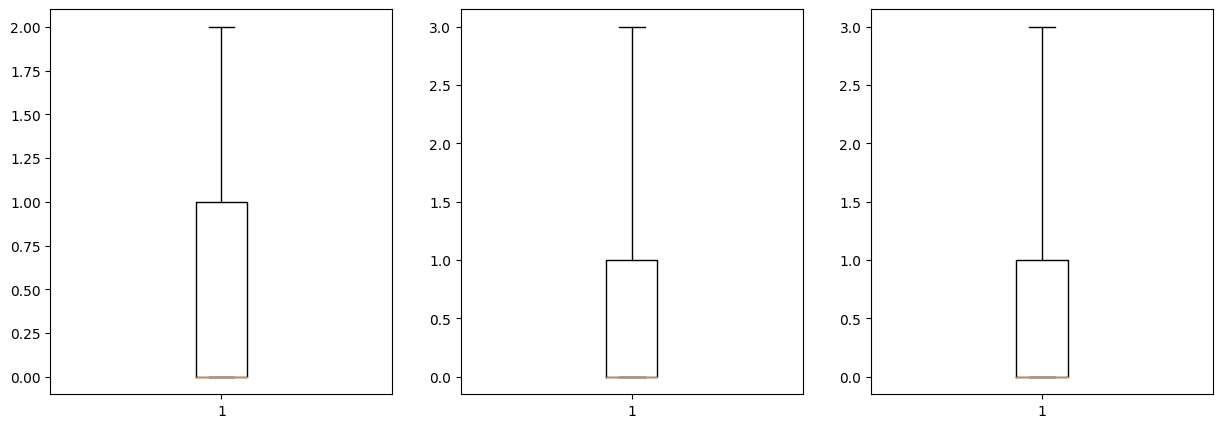

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .08)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .06)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .04)), whis=3)

plt.show()

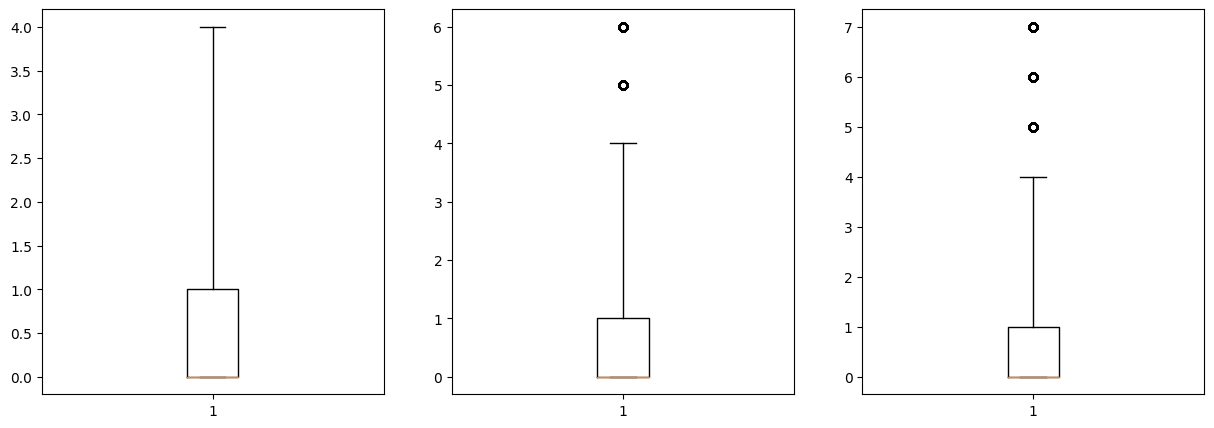

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .02)), whis=3)

plt.subplot(1, 3, 2)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .01)), whis=3)

plt.subplot(1, 3, 3)
plt.boxplot(stats.mstats.winsorize(df['number_inpatient'], (0, .005)), whis=3)

plt.show()

In [ ]:
df['winsorized_number_inpatient'] = stats.mstats.winsorize(df['number_inpatient'], (0, .02))
df.drop('number_inpatient', axis=1, inplace=True)

number_inpatient proved much easier to winsorize.

# Data Exploration - Univariate

Now I'll start the data exploration phase. First I'll do univariate data exploration and then move on to multivariate. I'll start by looking at the descriptive statistics and histograms of the continuous variables, using the winsorized versions where applicable.

In [ ]:
df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'winsorized_num_medications',
    'winsorized_number_inpatient', 'number_diagnoses']].describe()

,time_in_hospital,num_lab_procedures,num_procedures,winsorized_num_medications,winsorized_number_inpatient,number_diagnoses
count,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000,100241.000000
mean,4.420307,43.173991,1.350236,16.077154,0.588123,7.497052
std,2.991258,19.691339,1.710899,7.924860,1.013023,1.839509
min,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000
25%,2.000000,32.000000,0.000000,11.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,48.000000,4.000000,16.000000


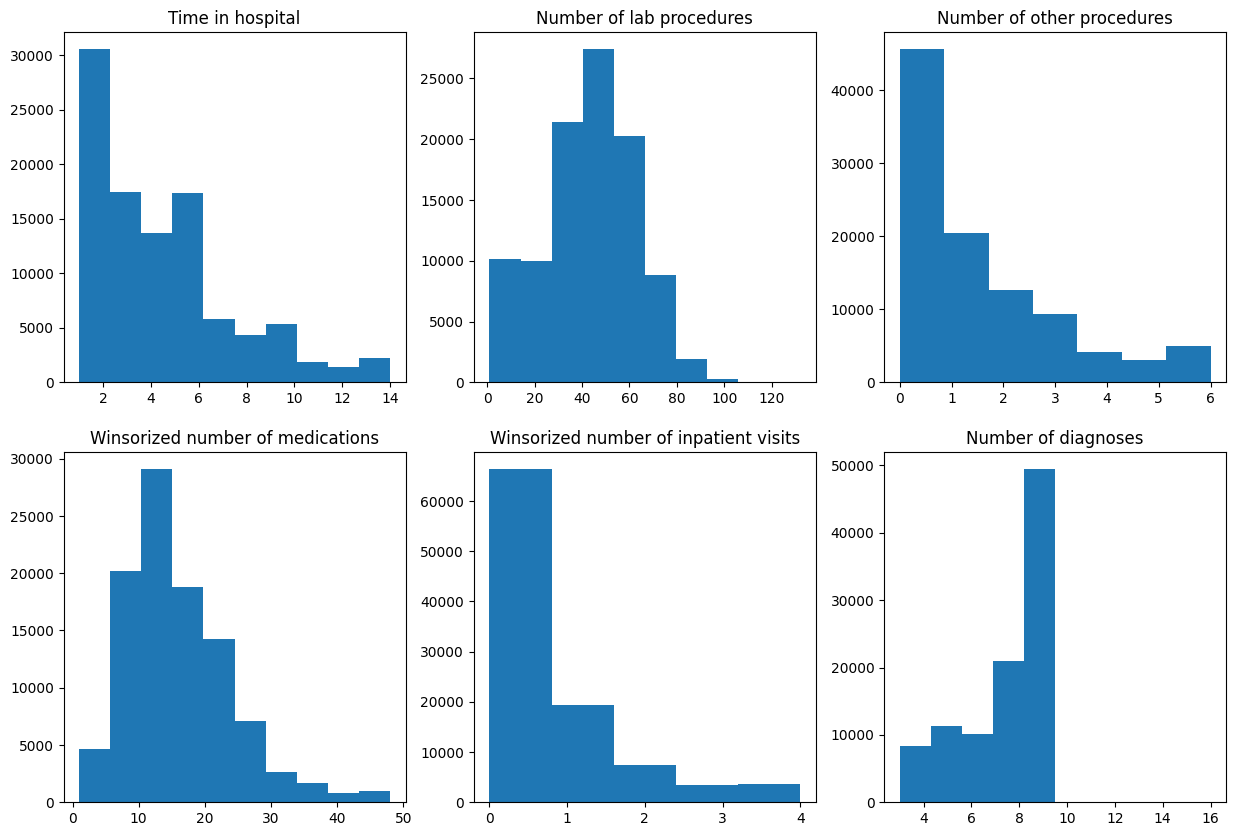

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
plt.hist(df['time_in_hospital'])
plt.title('Time in hospital')

plt.subplot(2, 3, 2)
plt.hist(df['num_lab_procedures'])
plt.title('Number of lab procedures')

plt.subplot(2, 3, 3)
plt.hist(df['num_procedures'], bins=7)
plt.title('Number of other procedures')

plt.subplot(2, 3, 4)
plt.hist(df['winsorized_num_medications'])
plt.title('Winsorized number of medications')

plt.subplot(2, 3, 5)
plt.hist(df['winsorized_number_inpatient'], bins=5)
plt.title('Winsorized number of inpatient visits')

plt.subplot(2, 3, 6)
plt.hist(df['number_diagnoses'])
plt.title('Number of diagnoses')

plt.show()

Now I'll do some univariate data exploration on the categorical variables.

In [ ]:
df.describe(include=['O'])

,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,100241,100241,100241,100241,100241,100241,100241,100241,100241,100241,...,100241,100241,100241,100241,100241,100241,100241,100241,100241,100241
unique,6,2,10,715,743,789,4,4,4,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),428,428,250,None,None,No,No,...,No,No,No,No,No,No,No,No,Yes,NO
freq,75079,53922,25896,6853,6657,11533,94978,83642,80541,98708,...,100241,46799,99546,100228,100240,100239,100240,53891,77153,53818


I'll define a function to plot 9 bar charts simultaneously and use it for all of the categorical variables.

In [ ]:
def barchart(vars):
  plt.figure(figsize=(18,18))
  for i in range(len(vars)):
    plt.subplot(3,3,i+1)
    plt.title(vars[i])
    plt.xticks(rotation=45)
    plt.bar(df.groupby(vars[i])[vars[i]].count().index,
         df.groupby(vars[i])[vars[i]].count())
  
  plt.show()

The y labels for diag_1, diag_2, and diag_3 would be messy if I used the function because there are over 700 values for each of those. I'll instead plot those ones on their own and then use the function for the rest of the variables.

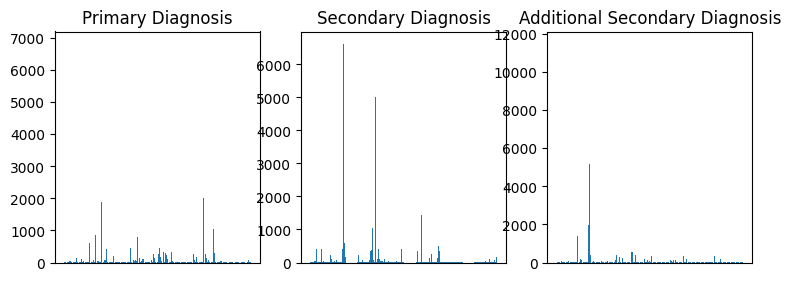

In [ ]:
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.xticks([])
plt.title('Primary Diagnosis')
plt.bar(df.groupby('diag_1')['diag_1'].count().index,
         df.groupby('diag_1')['diag_1'].count())

plt.subplot(1,3,2)
plt.xticks([])
plt.title('Secondary Diagnosis')
plt.bar(df.groupby('diag_2')['diag_2'].count().index,
         df.groupby('diag_2')['diag_2'].count())

plt.subplot(1,3,3)
plt.xticks([])
plt.title('Additional Secondary Diagnosis')
plt.bar(df.groupby('diag_3')['diag_3'].count().index,
         df.groupby('diag_3')['diag_3'].count())

plt.show()

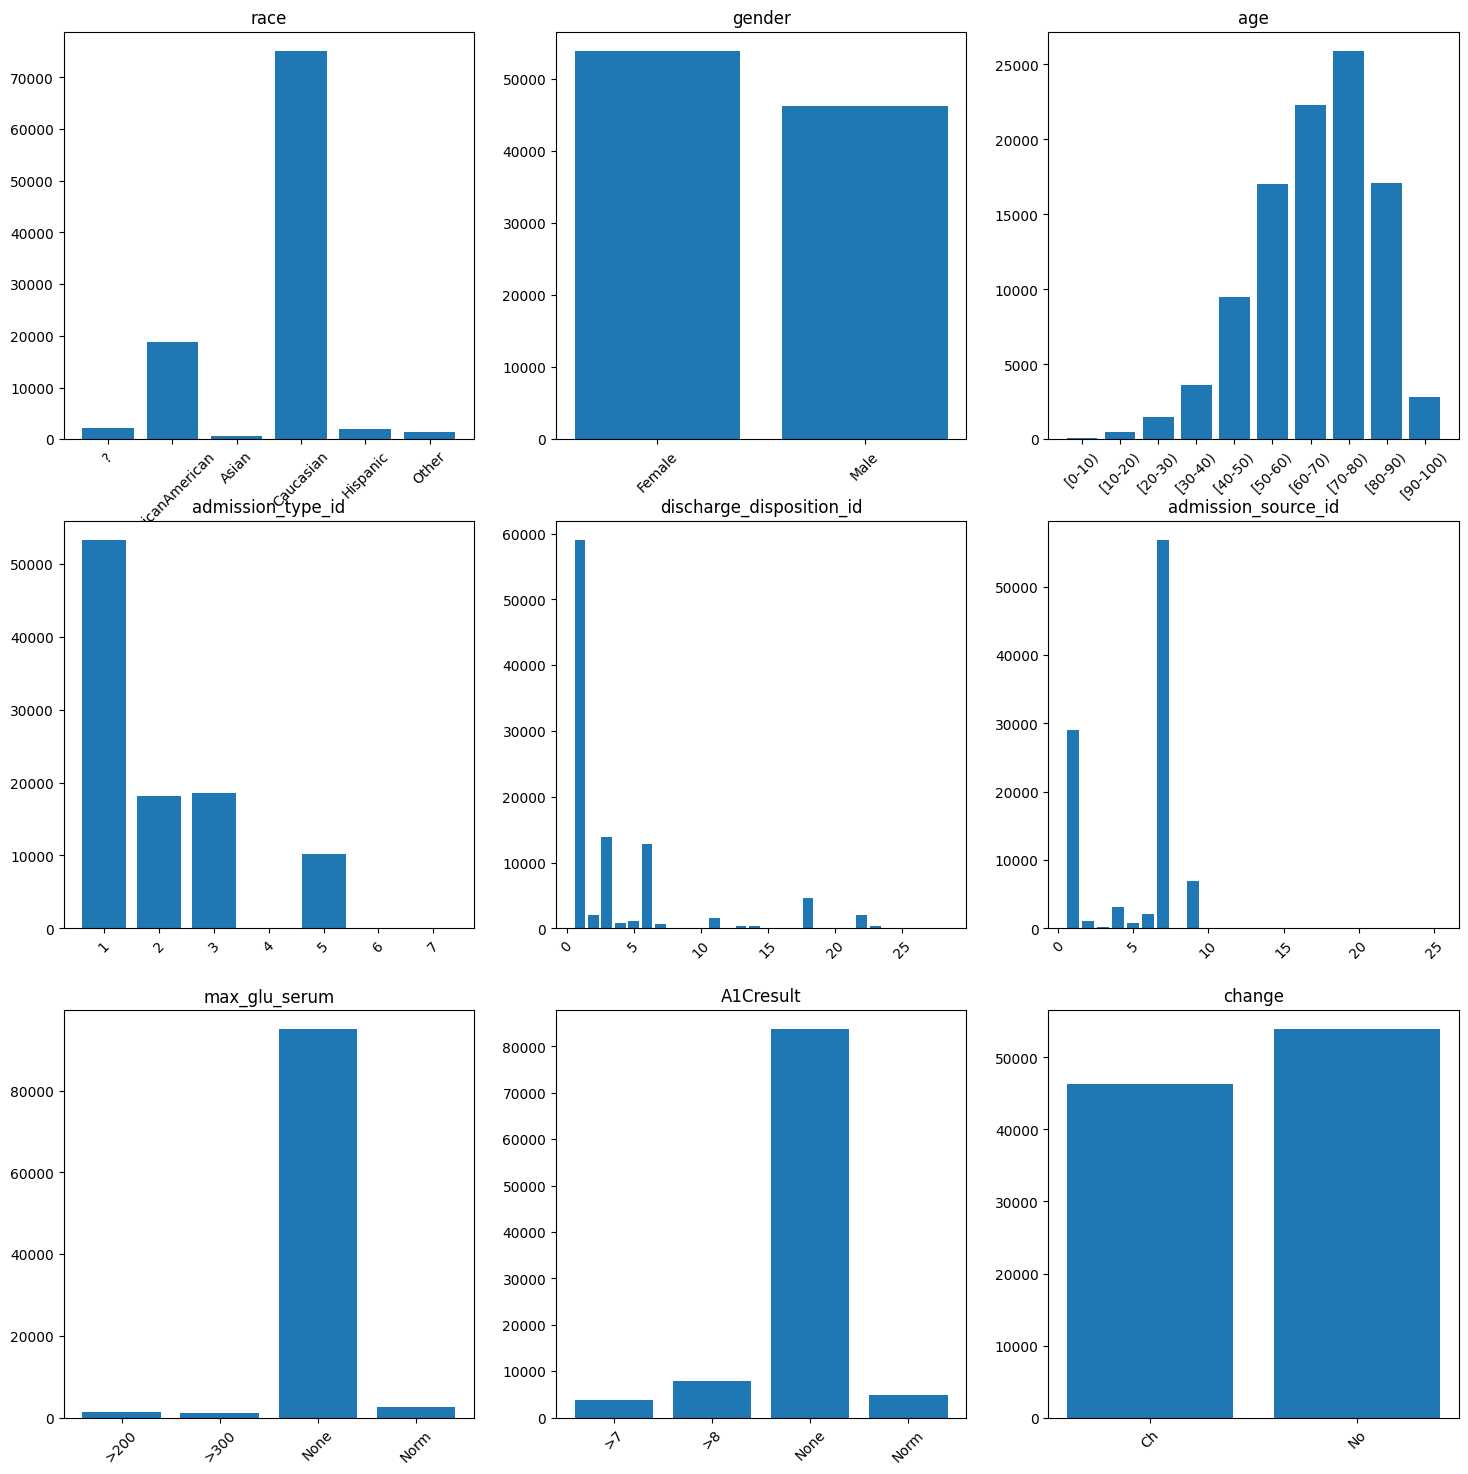

In [ ]:
barchart(['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
          'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change'])

The most common values for admission_type_id, discharge_disposition_id, and admission_source_id correspond to emergency, discharged to home, and emergency room respectively. Again, the full list of values corresponding to the IDs can be found by downloading the data folder through the link at the top of the notebook.

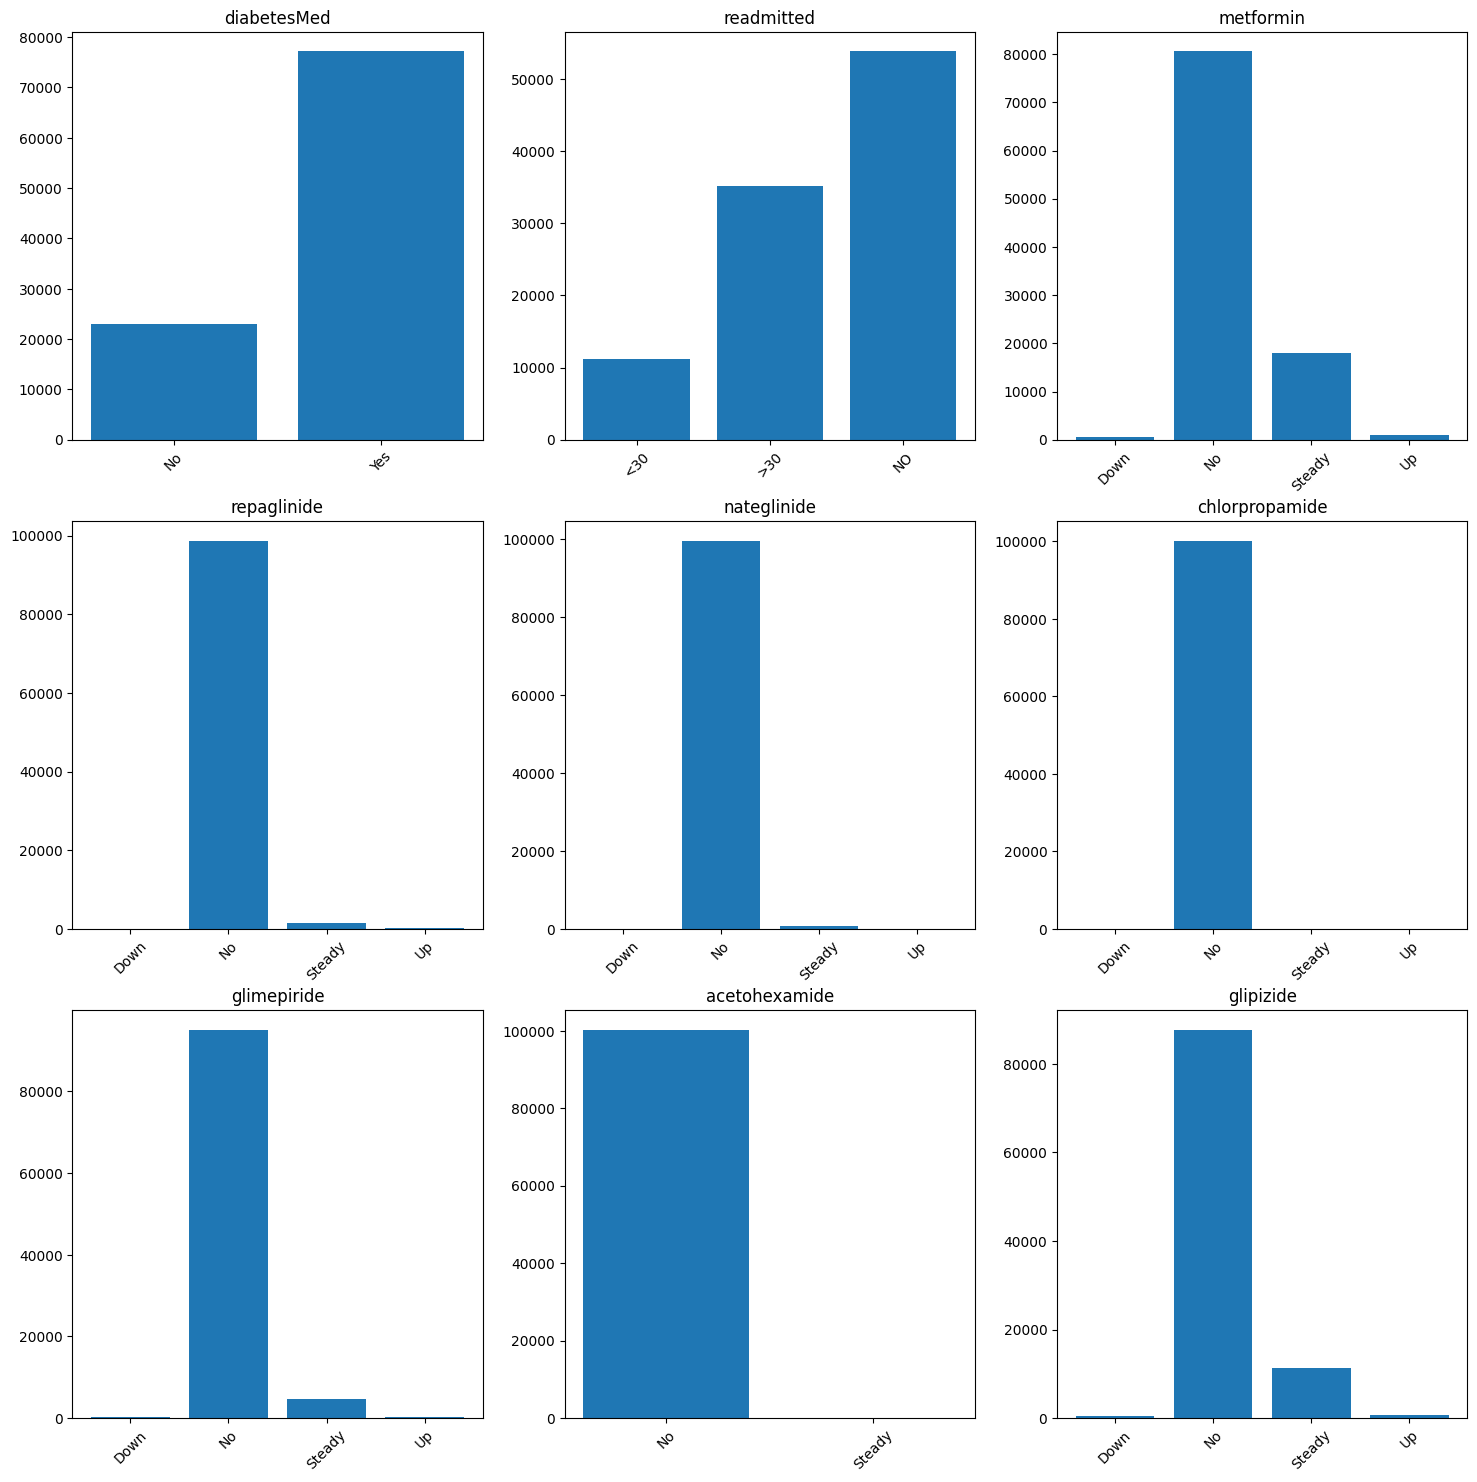

In [ ]:
barchart(['diabetesMed', 'readmitted', 'metformin', 'repaglinide', 'nateglinide',
          'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide'])

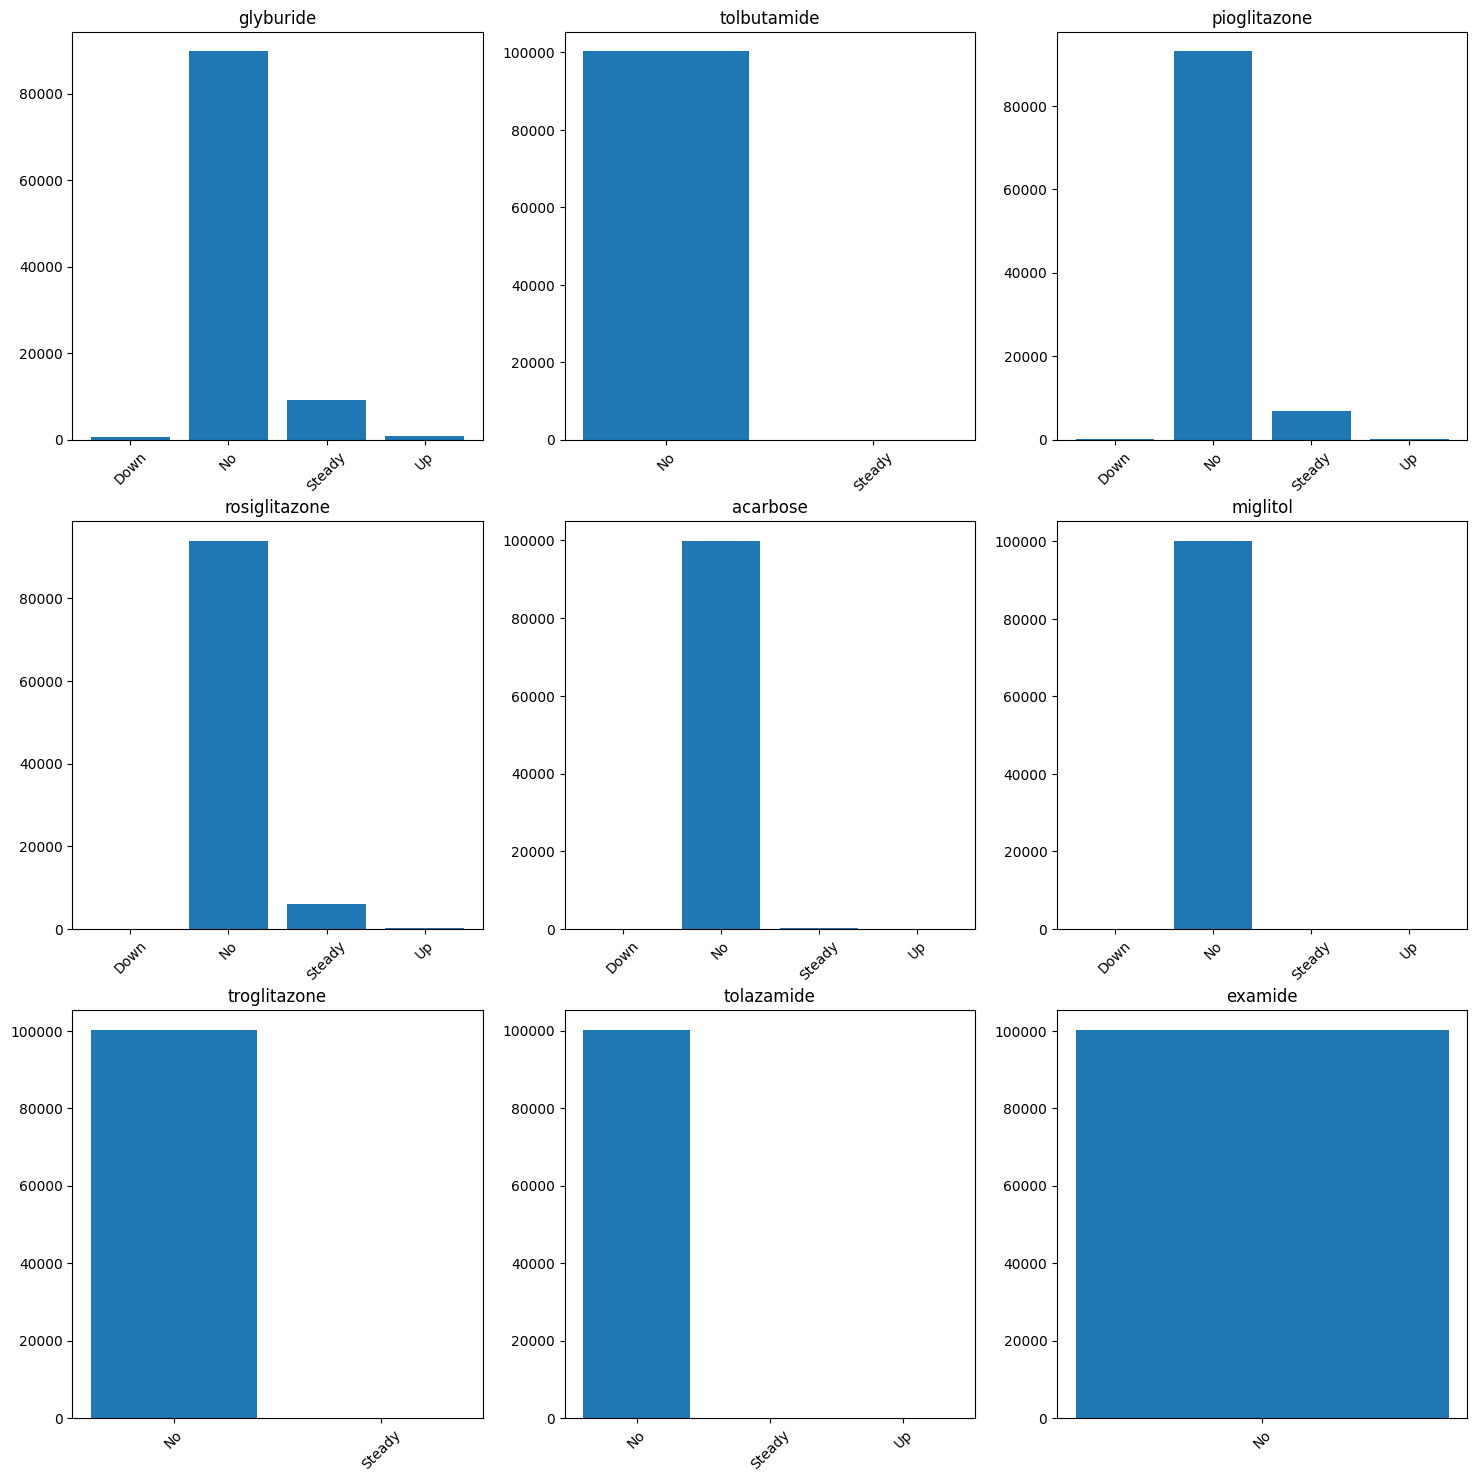

In [ ]:
barchart(['glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
          'miglitol', 'troglitazone', 'tolazamide', 'examide'])

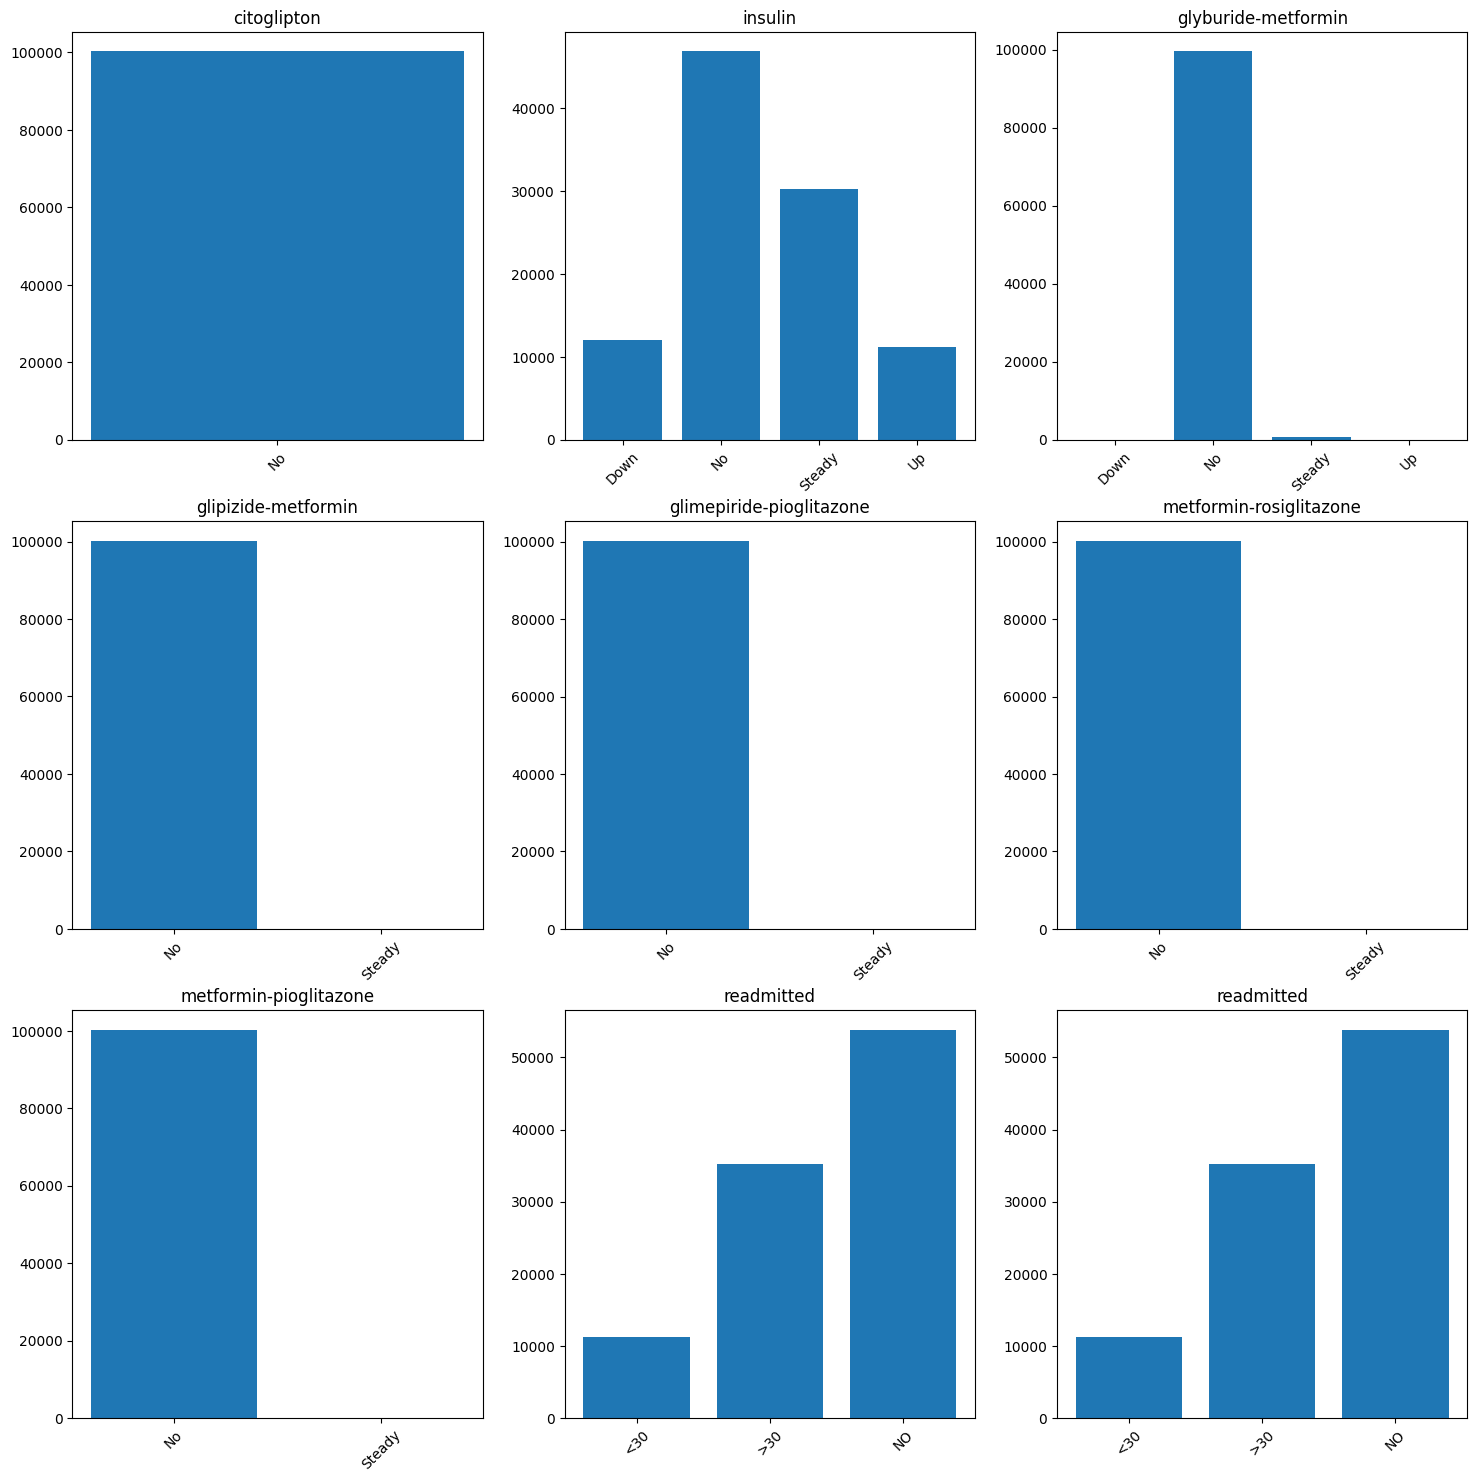

In [ ]:
barchart(['citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone',
          'readmitted', 'readmitted'])

In order to avoid a list index error, I added the target variable two more times to the final batch of bar plots. Some of the medications weren't prescribed to any of the patients, making them completely useless as potential features. There were also some that were prescribed to very few patients, which means that they aren't much more helpful as predictors and will only slow the model down. I'll drop all the medicines with more than 95000 values of No from the dataframe.

In [ ]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
               'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
               'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
               'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

meds_to_drop = []
for med in meds:
  if df[df[med] == 'No'][med].count() > 95000:
    meds_to_drop.append(med)

meds_to_drop

['repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'tolbutamide',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [ ]:
df.drop(meds_to_drop, axis=1, inplace=True)

There are 17 such medications. Now I'll move on to the multivariate analysis.

# Data Exploration - Multivariate

I'll start by looking at the correlation coefficients between the continuous variables.

In [ ]:
df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'winsorized_num_medications',
   'winsorized_number_inpatient', 'number_diagnoses']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,winsorized_num_medications,winsorized_number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.319328,0.189262,0.466968,0.082809,0.210353
num_lab_procedures,0.319328,1.000000,0.058283,0.270281,0.042985,0.151184
num_procedures,0.189262,0.058283,1.000000,0.380963,-0.075338,0.060142
winsorized_num_medications,0.466968,0.270281,0.380963,1.000000,0.072302,0.248360
winsorized_number_inpatient,0.082809,0.042985,-0.075338,0.072302,1.000000,0.119055
number_diagnoses,0.210353,0.151184,0.060142,0.248360,0.119055,1.000000


The correlations range from weak to moderate, the strongest being 0.47 between winsorized_num_medications and time_in_hospital. Next I'll look at the mean values for each continuous variable with respect to each value of the target variable.

In [ ]:
(df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'winsorized_num_medications',
   'winsorized_number_inpatient', 'number_diagnoses', 'readmitted']]).groupby('readmitted').mean()

,time_in_hospital,num_lab_procedures,num_procedures,winsorized_num_medications,winsorized_number_inpatient,number_diagnoses
readmitted,,,,,,
<30,4.783200,44.263644,1.287200,16.906400,1.030844,7.735911
>30,4.512325,43.883064,1.256532,16.323828,0.775197,7.700850
NO,4.284310,42.482794,1.424653,15.742595,0.373314,7.313928


The differences between these values aren't huge but in order to be more certain of whether or not there are statistically significant differences, I'll perform t-tests.

In [ ]:
outcomes = ['<30', '>30', 'NO']
for var in ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'winsorized_num_medications',
   'winsorized_number_inpatient', 'number_diagnoses']:
   print('-'*50)
   print(f'T-tests for {var}:\n')
   print('-'*50)
   for i in range(0,len(outcomes)):
    for j in range(i+1, len(outcomes)):
      print(f'T-test between {outcomes[i]} and {outcomes[j]}')
      print(stats.ttest_ind(
          df[df['readmitted'] == outcomes[i]][var],
          df[df['readmitted'] == outcomes[j]][var]
      ))

--------------------------------------------------
T-tests for time_in_hospital:

--------------------------------------------------
T-test between <30 and >30
Ttest_indResult(statistic=8.332110363140941, pvalue=8.156057337541147e-17)
T-test between <30 and NO
Ttest_indResult(statistic=16.126670947298912, pvalue=2.1517432986893736e-58)
T-test between >30 and NO
Ttest_indResult(statistic=11.156517641333279, pvalue=6.95533697406455e-29)
--------------------------------------------------
T-tests for num_lab_procedures:

--------------------------------------------------
T-test between <30 and >30
Ttest_indResult(statistic=1.8012503383374914, pvalue=0.07166991828896359)
T-test between <30 and NO
Ttest_indResult(statistic=8.70657704443336, pvalue=3.2036070283242227e-18)
T-test between >30 and NO
Ttest_indResult(statistic=10.35275896104949, pvalue=4.201734727276407e-25)
--------------------------------------------------
T-tests for num_procedures:

-------------------------------------------

There are three results here that indicate differences that are not statistically significant: number_diagnoses (between <30 and >30), num_procedures (between <30 and >30), and num_lab_procedures (between <30 and >30). Importantly, there were always statistically significant differences between the two readmitted categories and the not readmitted category. These seem to be useful variables and should be considered as potential features. Now I'll take a look at the relationships between each of the categorical variables and the target variable using countplots and chi square tests to determine if the distributions of each variable with respect to the target variable are statistically significant.

In [ ]:
cat_vars = df.columns.tolist()
for var in ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'winsorized_num_medications',
   'winsorized_number_inpatient', 'number_diagnoses', 'readmitted']:
   cat_vars.remove(var)

def make_countplots(vars):
  plt.figure(figsize=(18,18))
  for i in range(len(vars)):
    plt.subplot(3,3,i+1)
    plt.title(vars[i])
    plt.xticks(rotation=45)
    sns.countplot(x=vars[i], hue='readmitted', data=df)
    plt.xlabel(None)

  plt.show()

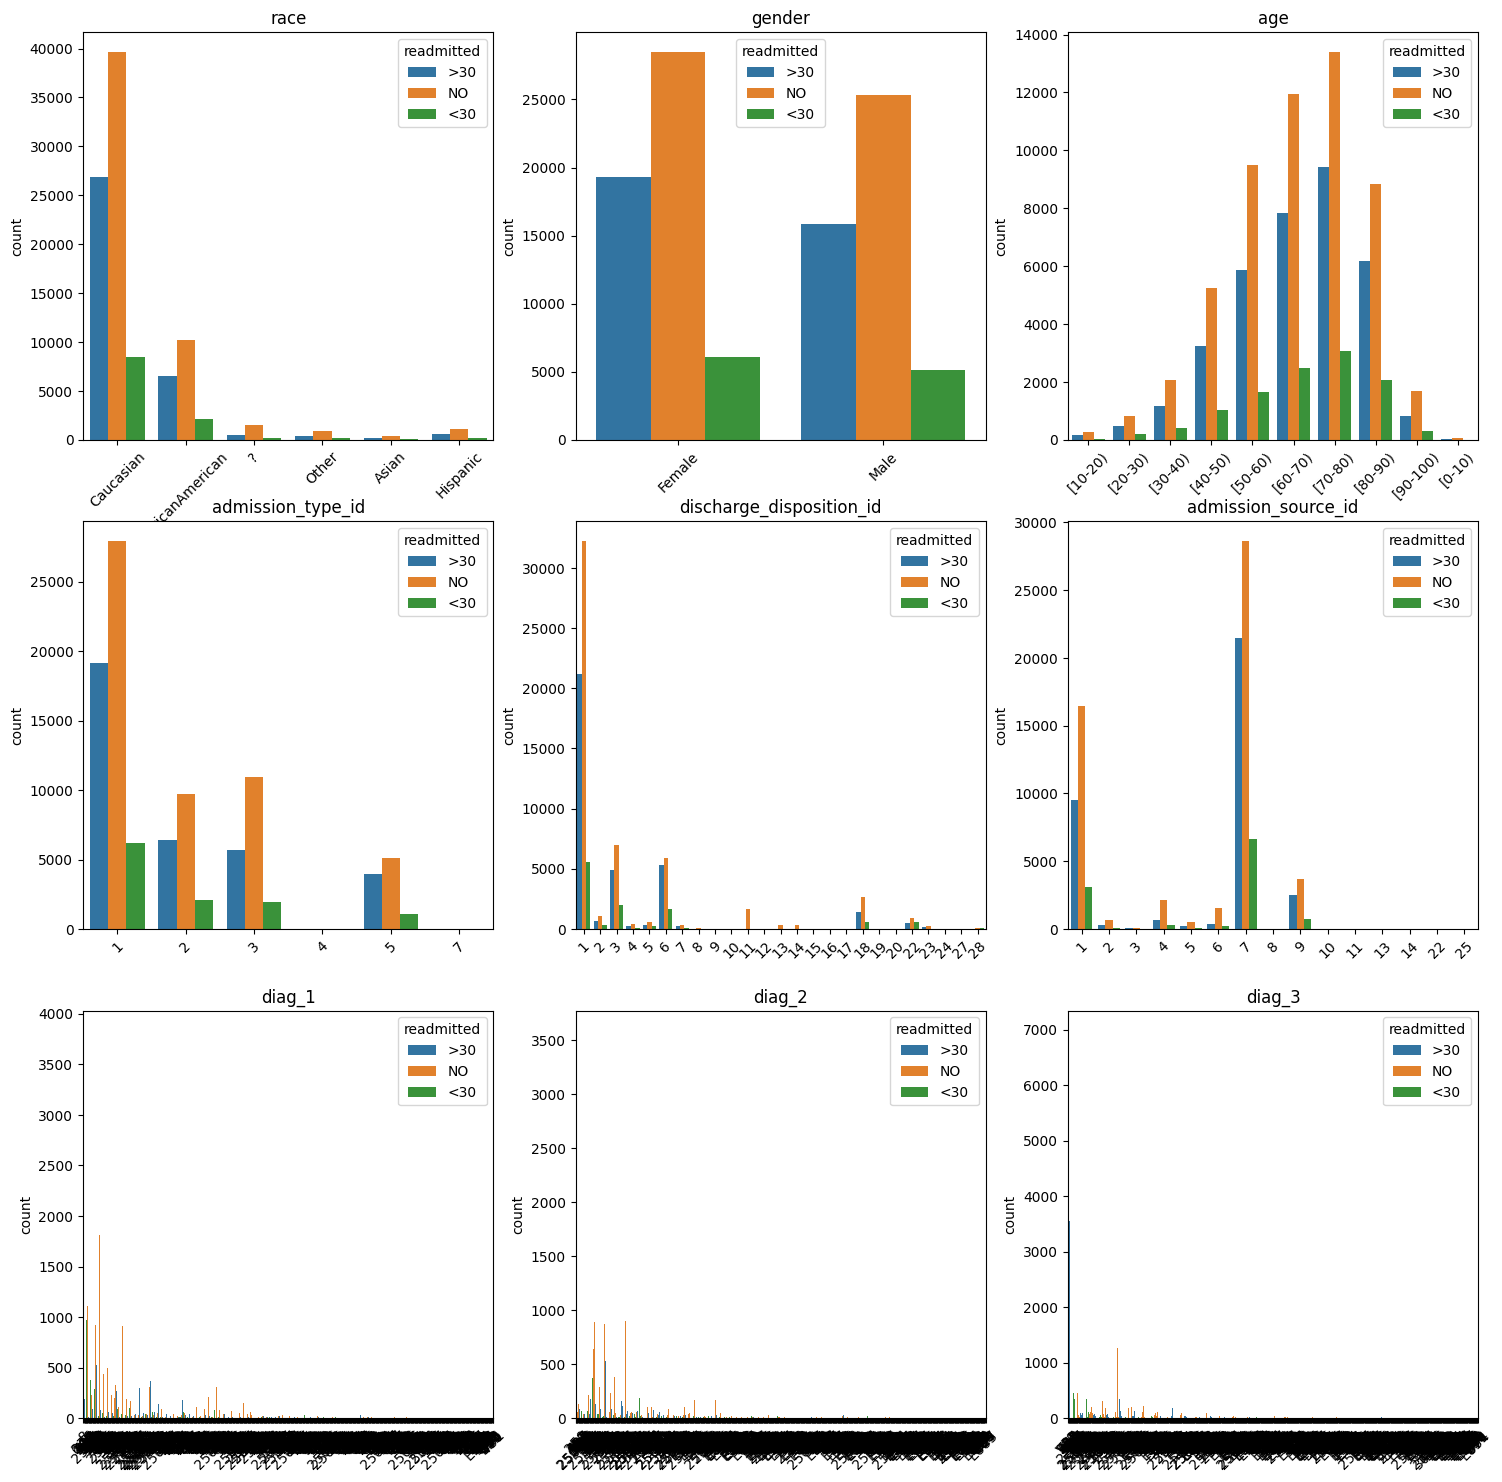

In [ ]:
make_countplots(cat_vars[:9])

The x-axes for the three diagnosis variables are a mess because there are so many categories for each of them. I'll have to address that in the feature engineering stage.

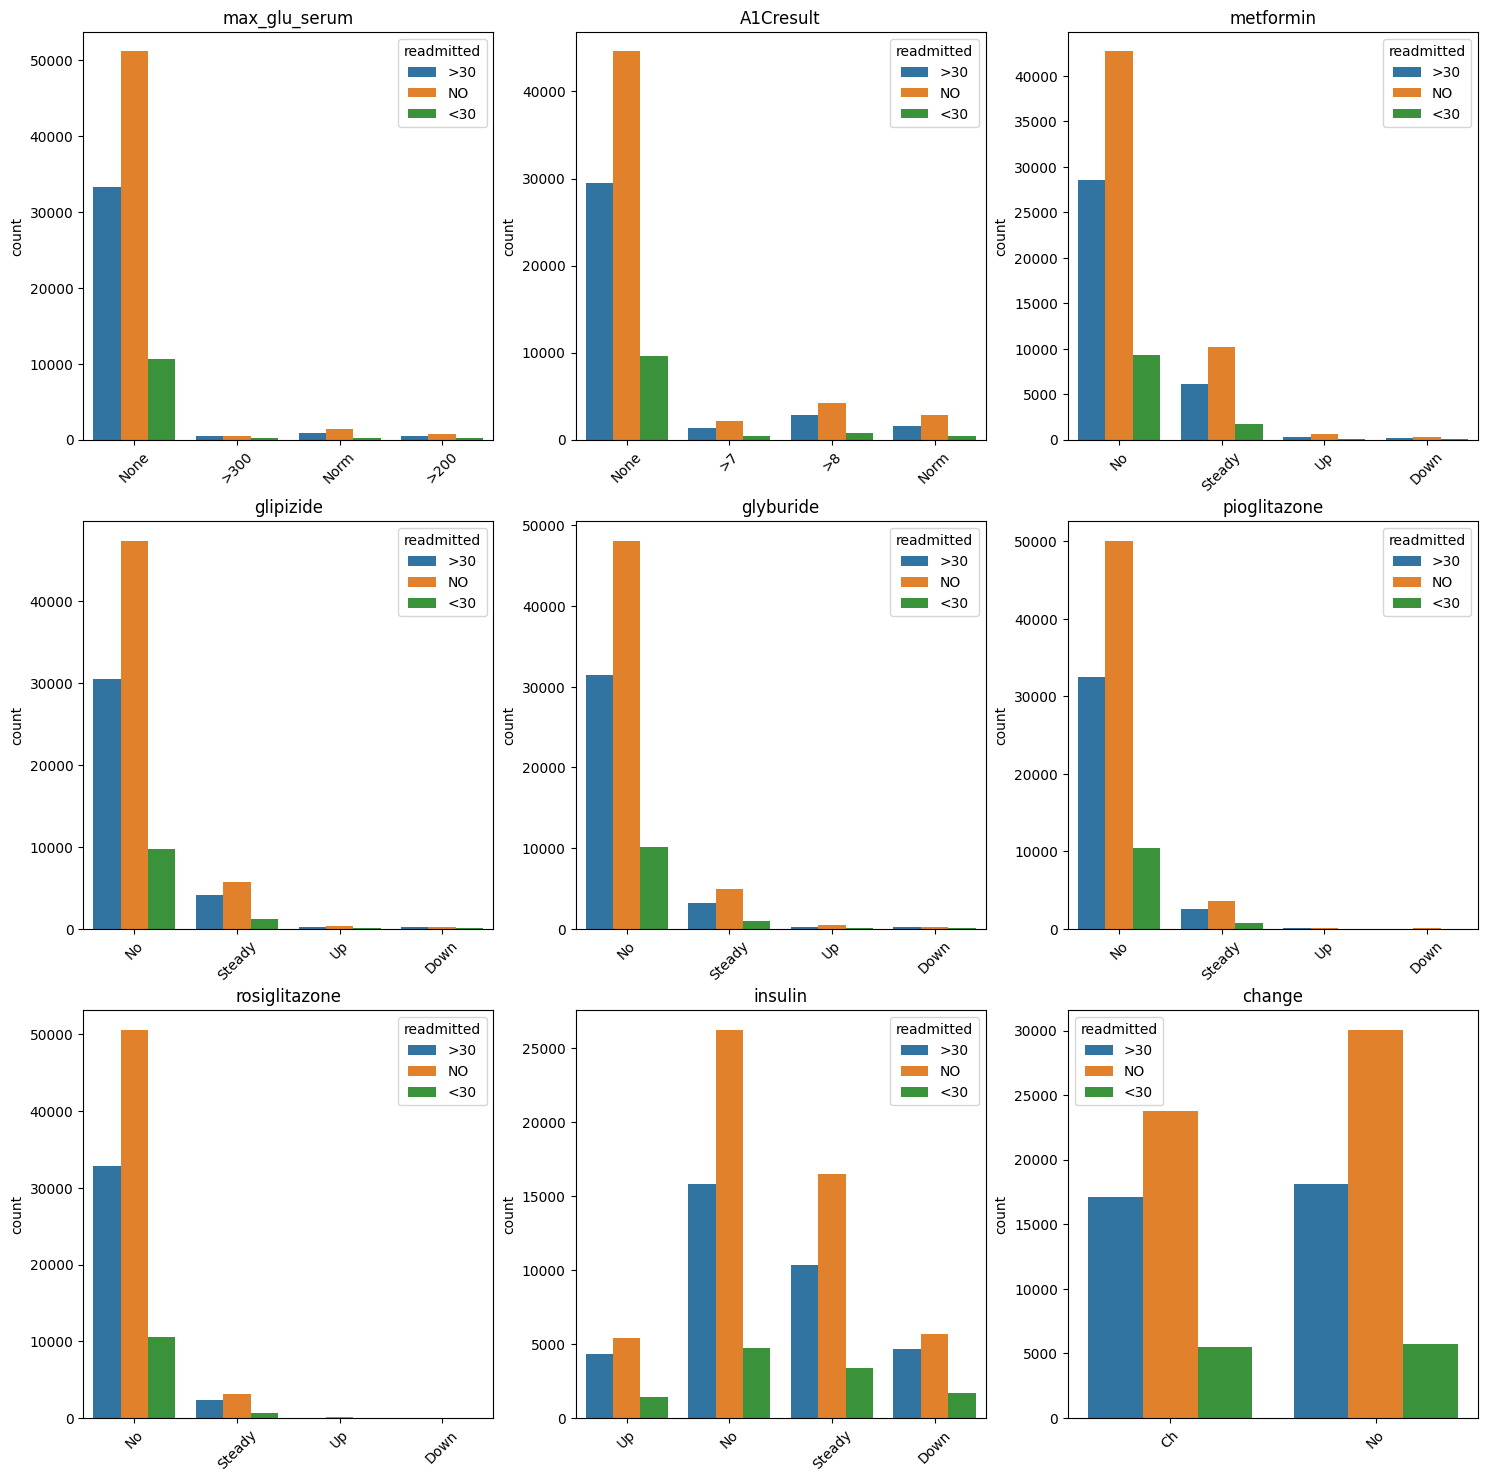

In [ ]:
make_countplots(cat_vars[9:18])

Text(0.5, 0, '')

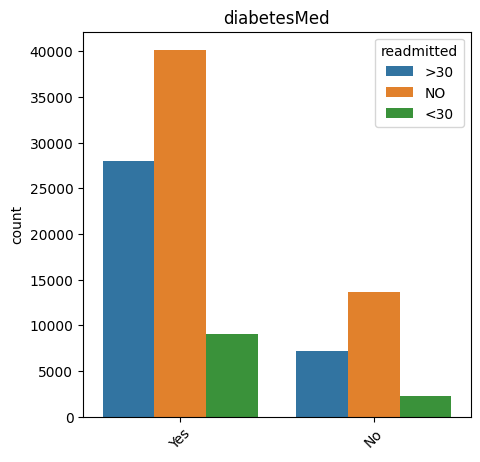

In [ ]:
plt.figure(figsize=(5,5))
plt.title('diabetesMed')
plt.xticks(rotation=45)
sns.countplot(x='diabetesMed', hue='readmitted', data=df)
plt.xlabel(None)

In [ ]:
crosstabs = []

for var in cat_vars:
  crosstabs.append([var, pd.crosstab(df['readmitted'], df[var])])

for entry in crosstabs:
  print(f'Chi square test for {entry[0]}')
  print(stats.chisquare(entry[1], axis=None))
  print('\n')

Chi square test for race
Power_divergenceResult(statistic=353536.1719954909, pvalue=0.0)


Chi square test for gender
Power_divergenceResult(statistic=27946.87452240102, pvalue=0.0)


Chi square test for age
Power_divergenceResult(statistic=135047.31206791633, pvalue=0.0)


Chi square test for admission_type_id
Power_divergenceResult(statistic=173451.8939056873, pvalue=0.0)


Chi square test for discharge_disposition_id
Power_divergenceResult(statistic=1156423.7382308636, pvalue=0.0)


Chi square test for admission_source_id
Power_divergenceResult(statistic=674523.6597200749, pvalue=0.0)


Chi square test for diag_1
Power_divergenceResult(statistic=1757090.214922038, pvalue=0.0)


Chi square test for diag_2
Power_divergenceResult(statistic=2241805.151764248, pvalue=0.0)


Chi square test for diag_3
Power_divergenceResult(statistic=3391984.1783102723, pvalue=0.0)


Chi square test for max_glu_serum
Power_divergenceResult(statistic=359034.60399437364, pvalue=0.0)


Chi square test for A1

The p values are all sufficiently low to reject the null hypothesis. Therefore these distributions appear to be significantly different from the chi square distribution, which is a positive indication of their usefulness in the model.

# Feature Engineering

With 24 of the less useful variables from the original dataset having been eliminated, the feature engineering stage is already well underway. Most of the remaining variables are categorical, which means I'll have to use one-hot encoding to create dummy variables. This could become a problem because the abundance of dummy variables combined with the large size of the dataset could lead to long training times for the models.

The three diagnosis variables (diag_1, diag_2, and diag_3) have over 700 categories each. I'll start by reducing those into 9 categories each. As they currently stand, each of the categories is an icd9 code that corresponds to a specific diagnosis. Using table 2 from the original paper that posted this dataset (link: https://www.hindawi.com/journals/bmri/2014/781670/tab2/) I'll group the diagnoses by more general categories of diagnoses (ex: circulatory).

In [ ]:
def map_to_category(icd9):
  try:
    icd9 = float(icd9)
  except ValueError:
    icd9 = icd9

  if (isinstance(icd9, float) and 390 <= icd9 <= 459) or icd9 == 785:
    return 'circulatory'
  elif (isinstance(icd9, float) and 250 <= icd9 < 251):
    return 'diabetes'
  elif (isinstance(icd9, float) and 460 <= icd9 <= 519) or icd9 == 786:
    return 'respiratory'
  elif (isinstance(icd9, float) and 520 <= icd9 <= 579) or icd9 == 787:
    return 'digestive'
  elif (isinstance(icd9, float) and 800 <= icd9 <= 999):
    return 'injury'
  elif (isinstance(icd9, float) and 710 <= icd9 <= 739):
    return 'musculosketal'
  elif (isinstance(icd9, float) and 580 <= icd9 <= 629) or icd9 == 788:
    return 'genitourinary'
  elif (isinstance(icd9, float) and 140 <= icd9 <= 239):
    return 'neoplasms'
  else:
    return 'other'

In [ ]:
df['reduced_diag_1'] = df['diag_1'].apply(map_to_category)
df['reduced_diag_2'] = df['diag_2'].apply(map_to_category)
df['reduced_diag_3'] = df['diag_3'].apply(map_to_category)

Now I'll do some exploratory data analysis on these newly reduced variables.

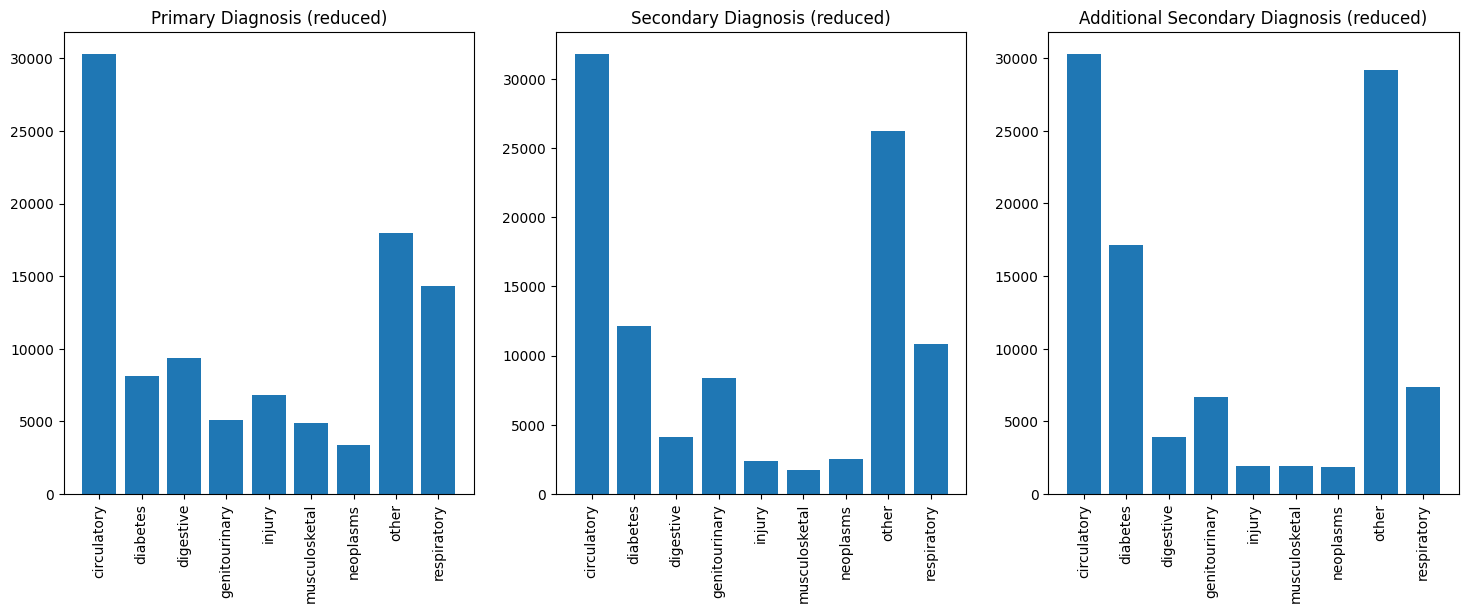

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title('Primary Diagnosis (reduced)')
plt.xticks(rotation=90)
plt.bar(df.groupby('reduced_diag_1')['reduced_diag_1'].count().index,
         df.groupby('reduced_diag_1')['reduced_diag_1'].count())

plt.subplot(1,3,2)
plt.title('Secondary Diagnosis (reduced)')
plt.xticks(rotation=90)
plt.bar(df.groupby('reduced_diag_2')['reduced_diag_2'].count().index,
         df.groupby('reduced_diag_2')['reduced_diag_2'].count())

plt.subplot(1,3,3)
plt.title('Additional Secondary Diagnosis (reduced)')
plt.xticks(rotation=90)
plt.bar(df.groupby('reduced_diag_3')['reduced_diag_3'].count().index,
         df.groupby('reduced_diag_3')['reduced_diag_3'].count())

plt.show()

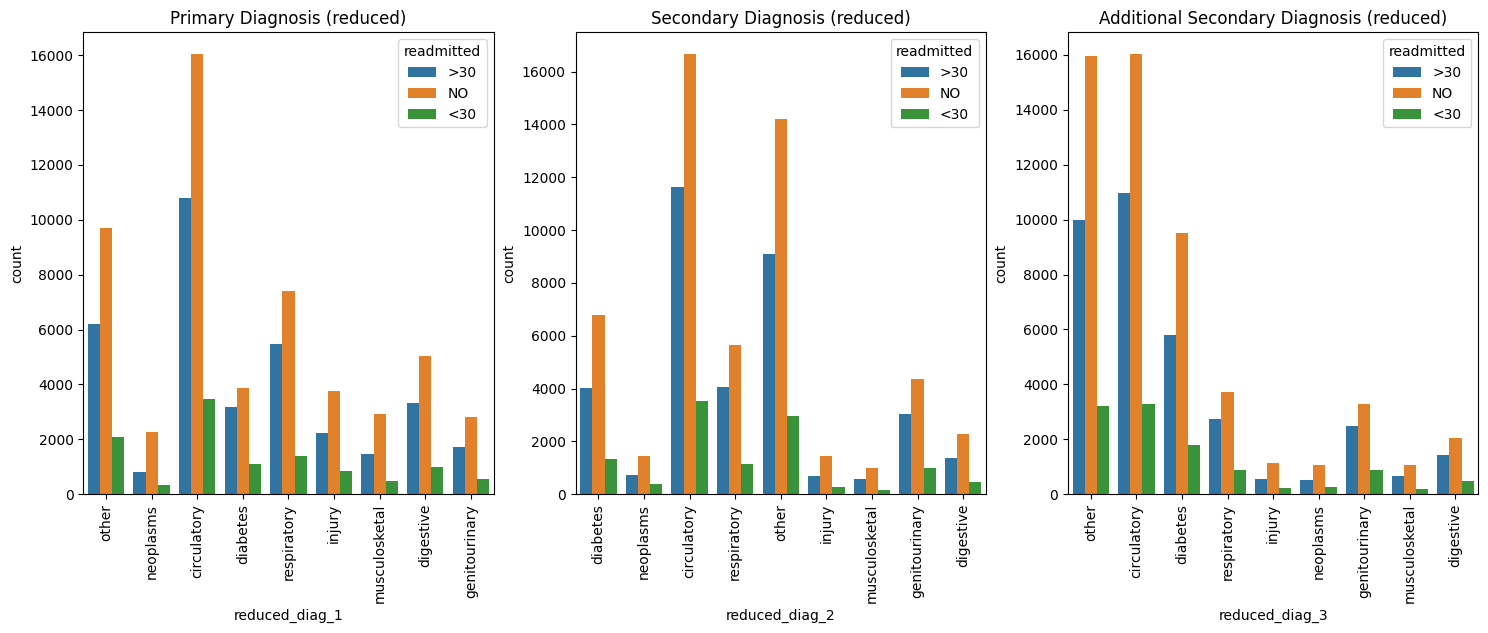

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title('Primary Diagnosis (reduced)')
plt.xticks(rotation=90)
sns.countplot(x='reduced_diag_1', hue='readmitted', data=df)

plt.subplot(1,3,2)
plt.title('Secondary Diagnosis (reduced)')
plt.xticks(rotation=90)
sns.countplot(x='reduced_diag_2', hue='readmitted', data=df)

plt.subplot(1,3,3)
plt.title('Additional Secondary Diagnosis (reduced)')
plt.xticks(rotation=90)
sns.countplot(x='reduced_diag_3', hue='readmitted', data=df)
plt.show()

In [ ]:
crosstabs = []
for var in ['reduced_diag_1', 'reduced_diag_2', 'reduced_diag_3']:
  crosstabs.append([var, pd.crosstab(df['readmitted'], df[var])])

for entry in crosstabs:
  print(f'Chi square test for {entry[0]}')
  print(stats.chisquare(entry[1], axis=None))
  print('\n')

Chi square test for reduced_diag_1
Power_divergenceResult(statistic=93985.11166089724, pvalue=0.0)


Chi square test for reduced_diag_2
Power_divergenceResult(statistic=135306.69213196196, pvalue=0.0)


Chi square test for reduced_diag_3
Power_divergenceResult(statistic=150612.18599175985, pvalue=0.0)




In [ ]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

This is much easier to work with. To have over 700 dummy variables for each of these three would have been a massive computational draw. This way, I'll retain a lot of the information of the original columns for a fraction of the computing time required.

Despite being a categorical variable (because it's reduced to intervals), age be encoded as numeric because higher numbers will be mathematically meaningful; for example: a value of 1 for [0-10) indicates a lower age than a value of 2 for [10-20).

In [ ]:
def map_ages(input):
  if input == '[0-10)':
    return 1
  elif input == '[10-20)':
    return 2
  elif input == '[20-30)':
    return 3
  elif input == '[30-40)':
    return 4
  elif input == '[40-50)':
    return 5
  elif input == '[50-60)':
    return 6
  elif input == '[60-70)':
    return 7
  elif input == '[70-80)':
    return 8
  elif input == '[80-90)':
    return 9
  else:
    return 10

df['age'] = df['age'].apply(map_ages)

The document with the details about the mapping of the discharge dispositions to unique integer IDs lists four IDs that correspond to patients that have died. A patient that has died can't possibly have been readmitted to the hospital so this is not a scenario worth studying for the purposes of this project. I'll drop all entries for patients that died.

In [ ]:
ids_to_drop = [11, 19, 20, 21]
#ids that represent expired, expired at home,
#expired in medical facility, and expired in unknown location

for id in ids_to_drop:
  df = df[df['discharge_disposition_id'] != id]

In [ ]:
df.shape

(98591, 26)

That elmiminates about 2,000 entries but the remaining data is far more useful. Next I'll use XGBoost's feature importances evaluation to assess the value of each feature. Then I'll choose the most important ones to use in my model.

In [ ]:
potential_features = df.columns.tolist()
cat_features = df.columns.tolist() #the categorical features
potential_features.remove('readmitted')
cat_features.remove('readmitted')
cat_features.remove('age') #removing age since I've encoded it numerically
cont_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'number_diagnoses',
            'winsorized_num_medications', 'winsorized_number_inpatient'] #the continuous features

for var in cont_features:
  cat_features.remove(var)

In [ ]:
X = df.drop('readmitted', axis=1)
Y = df['readmitted']

for feature in cat_features:
  X[feature] = X[feature].astype('category') #xgboost requires this for categorical features

def map_to_number(val):
  if val == '<30':
    return 0
  elif val == '>30':
    return 1
  else:
    return 2

Y = Y.apply(map_to_number) #xgboost requires the target to be of a numeric type

model = XGBClassifier(tree_method='hist', enable_categorical=True)
model.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Now I'll sort the features from most to least important and print out the feature name along with its importance.

In [ ]:
importances_dict = {}
importances_list = []

for i in range(len(potential_features)):
  importances_dict[potential_features[i]] = model.feature_importances_[i]
  importances_list.append(model.feature_importances_[i])

importances_list.sort(reverse=True)
key_list = list(importances_dict.keys())
value_list = list(importances_dict.values())

def return_key(input):
  for key, value in importances_dict.items():
    if input == value:
      return key

importances_pairs = []
for value in importances_list:
  importances_pairs.append((return_key(value), value))

print('Feature importances from highest to lowest:')
for pair in importances_pairs:
  print(f'Importance of {pair[0]}: {pair[1]}')

Feature importances from highest to lowest:
Importance of winsorized_number_inpatient: 0.33615759015083313
Importance of diabetesMed: 0.051514532417058945
Importance of number_diagnoses: 0.04780811443924904
Importance of discharge_disposition_id: 0.045504532754421234
Importance of admission_source_id: 0.043016012758016586
Importance of admission_type_id: 0.030984874814748764
Importance of age: 0.029766803607344627
Importance of reduced_diag_1: 0.028843147680163383
Importance of max_glu_serum: 0.027910739183425903
Importance of race: 0.027475623413920403
Importance of reduced_diag_2: 0.02596224844455719
Importance of metformin: 0.02516520395874977
Importance of num_procedures: 0.024829233065247536
Importance of reduced_diag_3: 0.024821901693940163
Importance of insulin: 0.023859014734625816
Importance of A1Cresult: 0.02346089482307434
Importance of winsorized_num_medications: 0.023168956860899925
Importance of time_in_hospital: 0.02155657298862934
Importance of glipizide: 0.021041231229

It seems that winsorized_number_inpatient is by far the most valuable feature in the model. Now I'll train a series of models adding one feature at a time (from most to least important) and compare the performances of the models. I'll stop adding features when the performance of the model plateaus. This is essentially sequential feature selection but doing it manually like this (instead of using the sci-kit learn implementation) and using XGBoost's enable_categorical, I'm able to consider each categorical feature as a single unit, rather than considering each one-hot encoded variable separately.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
features = []

for i in range(len(importances_pairs)):
  features.append(importances_pairs[i][0])
  model = XGBClassifier(tree_method='hist', enable_categorical=True)
  scores = []
  for score in cross_val_score(model, X[features], Y):
    scores.append(score)
  print(f'Number of features: {len(features)}')
  print(f'Average accuracy: {np.mean(scores)}')
  print('-'*50)

Number of features: 1
Average accuracy: 0.5587934220601151
--------------------------------------------------
Number of features: 2
Average accuracy: 0.5575458310265416
--------------------------------------------------
Number of features: 3
Average accuracy: 0.5610553188620229
--------------------------------------------------
Number of features: 4
Average accuracy: 0.5621203206810428
--------------------------------------------------
Number of features: 5
Average accuracy: 0.5615117895837058
--------------------------------------------------
Number of features: 6
Average accuracy: 0.5622927874541765
--------------------------------------------------
Number of features: 7
Average accuracy: 0.561177066951846
--------------------------------------------------
Number of features: 8
Average accuracy: 0.5617552338111909
--------------------------------------------------
Number of features: 9
Average accuracy: 0.5625970692057468
--------------------------------------------------
Number of f

In my exploratory data analysis, I noticed that for many of the variables, the difference between <30 and >30 was less substantial than the differences between each of those outcomes and NO. I'll try to do the same as above but this time with a binary outcome: YES and NO. This could lead to a more accurate model. In the event that a patient is categorized as YES, a hospital can err on the side of caution and adjust their treatment to prepare for an admission in the near future.

In [ ]:
def map_to_binary(val):
  if val == '<30' or val == '>30':
    return 1
  else:
    return 0

Y = Y.apply(map_to_binary)

model = XGBClassifier(tree_method='hist', enable_categorical=True)
model.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
importances_dict = {}
importances_list = []

for i in range(len(potential_features)):
  importances_dict[potential_features[i]] = model.feature_importances_[i]
  importances_list.append(model.feature_importances_[i])

importances_list.sort(reverse=True)
key_list = list(importances_dict.keys())
value_list = list(importances_dict.values())

def return_key(input):
  for key, value in importances_dict.items():
    if input == value:
      return key

importances_pairs = []
for value in importances_list:
  importances_pairs.append((return_key(value), value))

print('Feature importances from highest to lowest:')
for pair in importances_pairs:
  print(f'Importance of {pair[0]}: {pair[1]}')

Feature importances from highest to lowest:
Importance of winsorized_number_inpatient: 0.38061097264289856
Importance of diabetesMed: 0.0650392547249794
Importance of number_diagnoses: 0.048881255090236664
Importance of admission_source_id: 0.04362139105796814
Importance of discharge_disposition_id: 0.035319965332746506
Importance of age: 0.032065071165561676
Importance of admission_type_id: 0.029962942004203796
Importance of reduced_diag_1: 0.025764668360352516
Importance of race: 0.025682708248496056
Importance of insulin: 0.023883122950792313
Importance of metformin: 0.022762231528759003
Importance of max_glu_serum: 0.022429024800658226
Importance of reduced_diag_2: 0.022221989929676056
Importance of num_procedures: 0.021880444139242172
Importance of winsorized_num_medications: 0.021769993007183075
Importance of reduced_diag_3: 0.02135140262544155
Importance of A1Cresult: 0.020034195855259895
Importance of time_in_hospital: 0.019216230139136314
Importance of num_lab_procedures: 0.01

These importance values are similar to the ones for the multiclass model. I'll try cross validation for the binary classification the way I did with the multiclass models above but I'll stop after 10 variables since the model plateaued and didn't improve much with more features.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
features = []
importances_pairs = importances_pairs[:10]

for i in range(len(importances_pairs)):
  features.append(importances_pairs[i][0])
  model = XGBClassifier(tree_method='hist', enable_categorical=True)
  scores = []
  for score in cross_val_score(model, X[features], Y):
    scores.append(score)
  print(f'Number of features: {len(features)}')
  print(f'Average accuracy: {np.mean(scores)}')
  print('-'*50)

Number of features: 1
Average accuracy: 0.6126827262319492
--------------------------------------------------
Number of features: 2
Average accuracy: 0.6126827262319492
--------------------------------------------------
Number of features: 3
Average accuracy: 0.6126523198149746
--------------------------------------------------
Number of features: 4
Average accuracy: 0.6121451746464748
--------------------------------------------------
Number of features: 5
Average accuracy: 0.6106035379802525
--------------------------------------------------
Number of features: 6
Average accuracy: 0.6111004429148083
--------------------------------------------------
Number of features: 7
Average accuracy: 0.6134029488180526
--------------------------------------------------
Number of features: 8
Average accuracy: 0.6135449669952291
--------------------------------------------------
Number of features: 9
Average accuracy: 0.6140825463571066
--------------------------------------------------
Number of 

The model does perform somewhat better and the accuracy score isn't bad for a model that hasn't been tuned. The lack of improvement when adding new features is concerning, though. The model is nearly as good with only winsorized_number_inpatient as with all of the variables included as features. For the sake of computational efficiency, I'll drop most of these variables as features. It hardly seems necessary, though, to drop all but the best one. The other features could prove to be more useful when I use other algorithms or as I tune the models to optimize their performance. I'll proceed with the top 7 features:
 - winsorized_number_inpatient
 - diabetesMed
 - number_diagnoses
 - admission_source_id
 - discharge_disposition_id
 - age
 - admission_type_id

# Supervised Learning - Initial Models

For this project, I'll be trying out a variety of models to see which performs best. I'll start by creating a few basic supervised learning models to compare their performance. When I have a clearer picture of which algorithms perform better on this dataset, I'll focus my efforts on optimizing those models.

In [ ]:
features = ['winsorized_number_inpatient', 'diabetesMed', 'number_diagnoses',
            'admission_source_id', 'discharge_disposition_id', 'age', 'admission_type_id']

X = df[features]
X['diabetesMed'] = X['diabetesMed'].astype('category')
X['admission_source_id'] = X['admission_source_id'].astype('category')
X['discharge_disposition_id'] = X['discharge_disposition_id'].astype('category')
X['admission_type_id'] = X['admission_type_id'].astype('category')

Y = df['readmitted']
Y = Y.apply(map_to_binary)

In [ ]:
#XGBoost

xgb = XGBClassifier(tree_method='hist', enable_categorical=True)
xgb_scores = cross_val_score(xgb, X, Y)

XGBoost has different requirements for the data from the rest of the algorithms so I'll restructure the data for the other models.

In [ ]:
#adding continuous variabless
X = df[['winsorized_number_inpatient', 'number_diagnoses', 'age']]

#adding dummy variables
X = pd.concat([X, pd.get_dummies(df['diabetesMed'], drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['admission_source_id'], drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['discharge_disposition_id'], drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['admission_type_id'], drop_first=True)], axis=1)

X.columns = X.columns.astype(str)

Y = df['readmitted'].apply(map_to_binary)

In [ ]:
#Naive Bayes

nb = GaussianNB()
nb_scores = cross_val_score(nb, X, Y)

In [ ]:
# Logistic Regression

lr = LogisticRegression()
lr_scores = cross_val_score(lr, X, Y)

In [ ]:
print(f'XGBoost scores: {xgb_scores}')
print(f'Naive Bayes scores: {nb_scores}')
print(f'Logistic regression scores: {lr_scores}')

XGBoost scores: [0.60327603 0.6079217  0.60132874 0.62800487 0.62648342]
Naive Bayes scores: [0.48065318 0.52043818 0.48037326 0.4798154  0.47885181]
Logistic regression scores: [0.60510168 0.60589309 0.60249518 0.62825844 0.62932346]


Naive Bayes performs noticeably worse but XGBoost and logistic regression performed similarly well. I'll try to optimize each of those individually.

# XGBoost

In [ ]:
#reformatting the data to xgboost's specifications

features = ['winsorized_number_inpatient', 'diabetesMed', 'number_diagnoses',
            'admission_source_id', 'discharge_disposition_id', 'age', 'admission_type_id']

X = df[features]
X['diabetesMed'] = X['diabetesMed'].astype('category')
X['admission_source_id'] = X['admission_source_id'].astype('category')
X['discharge_disposition_id'] = X['discharge_disposition_id'].astype('category')
X['admission_type_id'] = X['admission_type_id'].astype('category')

Y = df['readmitted'].apply(map_to_number)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

I'll use the F1 score to evaluate the models. This should be more useful than accuracy, as it will put more emphasis on the importance of identifying positives correctly. Incorrectly identifying a patient that will be readmitted as one that won't be could lead to the patient not receiving the care and treatment that they need, which is a bigger concern than a patient receiving more medical attention than is necessary.

In [ ]:
learning_rate = [.1, .15, .2, .25, .3]
n_estimators = [100, 200, 300, 400, 500]
max_depth = [3, 5, 7, 9]
colsample_bytree = [.5, .7, .9]
subsample = [.6, .8, 1]

random_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample,
               'enable_categorical': [True],
               'tree_method': ['hist']}

In [ ]:
xgb = XGBClassifier()

xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid,
                               n_iter = 100, verbose=2, scoring='f1', cv=5)

xgb_random.fit(X, Y)

In [ ]:
xgb_random.best_params_

{'tree_method': 'hist',
 'subsample': 0.8,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.15,
 'enable_categorical': True,
 'colsample_bytree': 0.9}

I'll now use grid search to search for the best hyperparameter values in the vicinity of the best values used in the randomized search.

In [ ]:
learning_rate = [.125, .15, .175]
n_estimators = [50, 100, 150]
max_depth = [4, 5, 6]
colsample_bytree = [.9, 1]
subsample = [.7, .8, .9]

search_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample,
               'enable_categorical': [True],
               'tree_method': ['hist']}

In [ ]:
xgb = XGBClassifier()

xgb_grid = GridSearchCV(estimator=xgb, param_grid=search_grid,
                        verbose=2, scoring='f1', cv=5)

xgb_grid.fit(X,Y)

In [ ]:
xgb_grid.best_params_

{'colsample_bytree': 0.9,
 'enable_categorical': True,
 'learning_rate': 0.125,
 'max_depth': 6,
 'n_estimators': 100,
 'subsample': 0.8,
 'tree_method': 'hist'}

I'll evaluate the model using the best hyperparameter values.

In [ ]:
xgb = XGBClassifier(tree_method='hist', subsample=.8, n_estimators=100, max_depth=6,
                    learning_rate=.125, enable_categorical=True, colsample_bytree=.9)

xgb.fit(X_train, Y_train)
print(f'F1 score: {metrics.f1_score(xgb.predict(X_test), Y_test)}')
print(f'Train accuracy: {xgb.score(X_train, Y_train)}')
print(f'Test accuracy: {xgb.score(X_test, Y_test)}')

F1 score: 0.561890580719535
Train accuracy: 0.6385053351906198
Test accuracy: 0.6299496916585524


I'll see if I can further improve the performance of the model by tuning the alpha regularization parameter.

In [ ]:
reg_alpha = [.0001, .001, .01, .1, 1]

alpha_grid = {'reg_alpha': reg_alpha}

alpha_search = GridSearchCV(estimator = XGBClassifier(colsample_bytree=.9, enable_categorical=True, learning_rate=.125,
                    max_depth=6, n_estimators=100, subsample=.8, tree_method='hist'),
                    param_grid=alpha_grid, verbose=2, cv=5)

alpha_search.fit(X, Y)

In [ ]:
alpha_search.best_params_

{'reg_alpha': 0.0001}

In [ ]:
xgb = XGBClassifier(tree_method='hist', subsample=.8, n_estimators=100, max_depth=6,
                    learning_rate=.125, enable_categorical=True, colsample_bytree=.9,
                    reg_alpha=.0001)

xgb.fit(X_train, Y_train)
print(f'F1 score: {metrics.f1_score(xgb.predict(X_test), Y_test)}')
print(f'Train accuracy: {xgb.score(X_train, Y_train)}')
print(f'Test accuracy: {xgb.score(X_test, Y_test)}')

F1 score: 0.568984962406015
Train accuracy: 0.6382483805093112
Test accuracy: 0.6278805582603051


Fortunately the model doesn't seem to be overfitting but it performs the same with and without reg_alpha being tuned and doesn't seem to have improved much. I'll now work on improving the logistic regression model.

# Logistic Regression

In [ ]:
#restructuring the data for logistic regression
X = df[['winsorized_number_inpatient', 'number_diagnoses', 'age']]

X = pd.concat([X, pd.get_dummies(df['diabetesMed'], drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['admission_source_id'], drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['discharge_disposition_id'], drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['admission_type_id'], drop_first=True)], axis=1)

X.columns = X.columns.astype(str)

Y = df['readmitted'].apply(map_to_binary)

Since different values of the solver hyperparameter are compatible with different types of penalties, I'll first find which value of solver is best for this model.

In [ ]:
solver_grid = {'solver': ['lbfgs', 'sag', 'saga', 'newton-cg', 'newton-cholesky']}

lr = LogisticRegression()
solver_search = GridSearchCV(estimator=lr, param_grid=solver_grid,
                        verbose=2, scoring='f1', cv=5)
solver_search.fit(X, Y)

In [ ]:
solver_search.best_params_

{'solver': 'lbfgs'}

The default lbfgs solver performed best. It's compatible with the penalties l2 and None.

In [ ]:
penalty = ['l2', None]
C = [.001, .01, .1, 1.0, 10.0, 100.0]
lr_grid = {'penalty': penalty, 'C': C}

lr = LogisticRegression()
lr_search = GridSearchCV(estimator=lr, param_grid=lr_grid,
                         verbose=2, scoring='f1', cv=5)
lr_search.fit(X, Y)

In [ ]:
lr_search.best_params_

{'C': 1.0, 'penalty': 'l2'}

I'll do another search for values of C, this time focusing on those closer to 1.

In [ ]:
c_grid = {'C': [.5, .75, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]}

lr = LogisticRegression()
c_search = GridSearchCV(estimator=lr, param_grid=c_grid,
                        verbose=2, scoring='f1', cv=5)
c_search.fit(X, Y)

In [ ]:
c_search.best_params_

{'C': 1.0}

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

lr = LogisticRegression(solver='lbfgs', penalty='l2', C=1.0)
print(f'Cross validation scores: {cross_val_score(lr, X, Y)}')

lr.fit(X_train, Y_train)
print(f'F1 score: {metrics.f1_score(lr.predict(X_test), Y_test)}')
print(f'Training accuracy: {lr.score(X_train, Y_train)}')
print(f'Test accuracy: {lr.score(X_test, Y_test)}')

Cross validation scores: [0.60510168 0.60589309 0.60249518 0.62825844 0.62932346]
F1 score: 0.5173132658768494
Training accuracy: 0.6203967921236628
Test accuracy: 0.6148571892242778


While the accuracies are similar, the XGBoost model has a higher F1 score than the logistic regression model. Therefore, the XGBoost model is the better one.

# Unsupervised Learning

I'll also create a few clustering models to see how those perform on the data. I'll have to do some more preprocessing to get the data into a format that works with clustering, such as scaling the data. Since I have a mix of categorical and continuous variables, I'll use the K-Prototypes algorithm. Given that I have a ground truth to work with, I'll evaluate the models using the adjusted rand index.

In [ ]:
X = df[['winsorized_number_inpatient', 'number_diagnoses']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

X = pd.concat([X.reset_index(drop=True), df[['age', 'diabetesMed', 'admission_source_id',
                                              'discharge_disposition_id', 'admission_type_id']].reset_index(drop=True)], axis=1)

X.columns = X.columns.astype(str)

#Y will be used for evaluating the models with the adjusted rand index
Y = df['readmitted'].apply(map_to_binary)

In [ ]:
kproto = KPrototypes(n_clusters=2)

#making a list of the indices of the categorical columns
cat_cols = list(range(len(X.columns.tolist())))
for num in [0, 1]:
  cat_cols.remove(num)

clusters = kproto.fit_predict(X, categorical=cat_cols)

print(f'KProto ARI: {metrics.adjusted_rand_score(clusters, Y)}')

KProto ARI: 0.011735149916310968


I'll also try a few other algorithms that don't work well with categorical variables. For those, I'll use only winsorized_number_inpatient, number_diagnoses, and age (since I encoded it numerically) as features. With winsorized_number_inpatient being so much more important than the rest of the features, I expect the performance of the models won't suffer too much.

In [ ]:
#restructuring the data once again
X = df[['winsorized_number_inpatient', 'number_diagnoses', 'age']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Y will be used for evaluating the models with the adjusted rand index
Y = df['readmitted'].apply(map_to_binary)

In [ ]:
clusters = KMeans(n_clusters=2).fit_predict(X)
print(f'K-Means ARI: {metrics.adjusted_rand_score(clusters, Y)}')

K-Means Adjusted Rand Index: 0.00999970697383716


In [ ]:
clusters = GaussianMixture(n_components=2).fit_predict(X)
print(f'Gaussian Mixture ARI: {metrics.adjusted_rand_score(clusters, Y)}')

Gaussian Mixture Adjusted Rand Index: 0.008566284238546617


None of these models is nearly as good as the supervised learning models I made. It's highly unlikely that they could be improved to anywhere near the performance of the XGBoost model, the current best one. Therefore, I'll move on and employ deep learning techniques to see if they're better suited to this model.

# Deep Learning

I'll create a basic artificial neural network and see how it performs on the data. In order to use the to_categorical method to transform the categorical variables, I'll need to put those variables into a format in which their values range from 0 to the number of unique values minus 1. Then I'll create X, scale it, and create Y.

In [ ]:
def map_diabetes(input):
  if input == 'Ch':
    return 1
  else:
    return 0

def map_admission_source_id(input):
  if input == 22:
    return 0
  elif input == 25:
    return 12
  else:
    return input

def map_discharge_disposition_id(input):
  if input == 22:
    return 0
  elif input == 23:
    return 11
  elif input == 24:
    return 19
  elif input == 27:
    return 20
  elif input == 28:
    return 21
  else:
    return input

def map_admission_type_id(input):
  if input == 7:
    return 0
  else:
    return input

In [ ]:
#restructuring the data for artificial neural networks
X = df[['winsorized_number_inpatient', 'number_diagnoses', 'age']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['winsorized_number_inpatient', 'number_diagnoses', 'age'])

diabetesMed = to_categorical(df['diabetesMed'].apply(map_diabetes), 2)
admission_source_id = to_categorical(df['admission_source_id'].apply(map_admission_source_id), 15)
discharge_disposition_id = to_categorical(df['discharge_disposition_id'].apply(map_discharge_disposition_id), 22)
admission_type_id = to_categorical(df['admission_type_id'].apply(map_admission_type_id), 6)

X = pd.concat([X, pd.DataFrame(diabetesMed)], axis=1)
X = pd.concat([X, pd.DataFrame(admission_source_id)], axis=1)
X = pd.concat([X, pd.DataFrame(discharge_disposition_id)], axis=1)
X = pd.concat([X, pd.DataFrame(admission_type_id)], axis=1)

X.columns = X.columns.astype(str)

Y = to_categorical(df['readmitted'].apply(map_to_binary), 2)

Now I'm ready to create an artificial neural network and see how it performs on the data.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

model = Sequential()
model.add(Dense(256, input_shape=(48,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
578/578 [==============================] - 3s 4ms/step - loss: 0.6794 - accuracy: 0.5879
Epoch 2/20
578/578 [==============================] - 3s 6ms/step - loss: 0.6623 - accuracy: 0.6083
Epoch 3/20
578/578 [==============================] - 3s 4ms/step - loss: 0.6567 - accuracy: 0.6111
Epoch 4/20
578/578 [==============================] - 3s 5ms/step - loss: 0.6548 - accuracy: 0.6124
Epoch 5/20
578/578 [==============================] - 2s 4ms/step - loss: 0.6535 - accuracy: 0.6140
Epoch 6/20
578/578 [==============================] - 3s 6ms/step - loss: 0.6526 - accuracy: 0.6150
Epoch 7/20
578/578 [==============================] - 2s 4ms/step - loss: 0.6517 - accuracy: 0.6163
Epoch 8/20
578/578 [==============================] - 3s 4ms/step - loss: 0.6510 - accuracy: 0.6177
Epoch 9/20
578/578 [==============================] - 2s 4ms/step - loss: 0.6504 - accuracy: 0.6184
Epoch 10/20
578/578 [==============================] - 3s 4ms/step - loss: 0.6498 - accuracy: 0.6191

In [ ]:
training_score = model.evaluate(X_train, Y_train)
test_score = model.evaluate(X_test, Y_test)

print(f'Training accuracy: {training_score[1]}')
print(f'Test accuracy: {test_score[1]}')

771/771 [==============================] - 1s 2ms/step - loss: 0.6456 - accuracy: 0.6225
Training accuracy: 0.6225606203079224
Test accuracy: 0.622525155544281


So far the ANN performs about the same as the XGBoost and logistic regression models. I'll build a function to create models by randomly choosing from a given set of hyperparameter values. Then I'll evaluate each model and see which hyperparameter values correspond to good models and which correspond to bad ones.

In [ ]:
def create_model():
  n_layers = np.random.randint(2, 5)
  n_neurons = np.random.choice(np.array([512, 256, 128]))
  neurons = [n_neurons]
  activation = np.random.choice(np.array(['relu', 'tanh', 'sigmoid']))
  loss = np.random.choice(np.array(['binary_crossentropy', 'hinge', 'squared_hinge']))
  lr = np.random.choice(np.array([.01, .001, .0001]))

  model = Sequential()
  model.add(Dense(n_neurons, input_shape=(48,), activation=activation))
  n_neurons /= 2

  for i in range(n_layers):
    model.add(Dense(n_neurons, activation=activation))
    neurons.append(n_neurons)
    n_neurons /= 2
  
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer=optimizers.experimental.SGD(learning_rate=lr), loss=loss, metrics=['accuracy'])

  hyper_params = {'n_layers': n_layers,
                  'neurons': neurons,
                  'activation': activation,
                  'loss': loss,
                  'learning rate': lr
                  }

  return model, hyper_params

models = []

for i in range(20):
  models.append(create_model())

In [ ]:
accuracies = []

for i in range(len(models)):
  models[i][0].fit(X_train, Y_train, batch_size=128, epochs=10)
  accuracies.append(models[i][0].evaluate(X_test, Y_test)[1])
  print(f'{i+1} model(s) tuned')

I'll print out the accuracies for each model and see how they performed.

In [ ]:
for i in range(len(accuracies)):
  print(f'Model {i} accuracy: {accuracies[i]}')

Model 0 accuracy: 0.6144108772277832
Model 1 accuracy: 0.6138023138046265
Model 2 accuracy: 0.5278724431991577
Model 3 accuracy: 0.4721275568008423
Model 4 accuracy: 0.5278724431991577
Model 5 accuracy: 0.6152223348617554
Model 6 accuracy: 0.6204965710639954
Model 7 accuracy: 0.5278724431991577
Model 8 accuracy: 0.5278724431991577
Model 9 accuracy: 0.5278724431991577
Model 10 accuracy: 0.5278724431991577
Model 11 accuracy: 0.5278724431991577
Model 12 accuracy: 0.612625777721405
Model 13 accuracy: 0.6165611743927002
Model 14 accuracy: 0.6173726320266724
Model 15 accuracy: 0.6169263124465942
Model 16 accuracy: 0.5278724431991577
Model 17 accuracy: 0.5278724431991577
Model 18 accuracy: 0.5278724431991577
Model 19 accuracy: 0.5278724431991577


Now I'll look at the hyperparameter dictionaries of the models that performed the worst.

In [ ]:
for i in range(len(accuracies)):
  if accuracies[i] < .55:
    print(f'Model {i}')
    pprint(models[i][1])
    print('-'*150)

Model 2
{'activation': 'sigmoid',
 'learning rate': 0.001,
 'loss': 'hinge',
 'n_layers': 2,
 'neurons': [128, 64.0, 32.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 3
{'activation': 'sigmoid',
 'learning rate': 0.0001,
 'loss': 'binary_crossentropy',
 'n_layers': 4,
 'neurons': [128, 64.0, 32.0, 16.0, 8.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 4
{'activation': 'sigmoid',
 'learning rate': 0.0001,
 'loss': 'squared_hinge',
 'n_layers': 2,
 'neurons': [256, 128.0, 64.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 7
{'activation': 'sigmoid',
 'learning rate': 0.01,
 'loss': 'squared_hinge',
 'n_layers': 4,
 'neurons': [256, 128.0, 64.0, 32.0, 16

11 of the 12 worst models used the sigmoid activation function, which seems like a clear indication that I shouldn't use it. Now I'll look at the best models.

In [ ]:
for i in range(len(accuracies)):
  if accuracies[i] > .6:
    print(f'Model {i}')
    pprint(models[i][1])
    print('-'*150)

Model 0
{'activation': 'tanh',
 'learning rate': 0.0001,
 'loss': 'squared_hinge',
 'n_layers': 2,
 'neurons': [512, 256.0, 128.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1
{'activation': 'tanh',
 'learning rate': 0.0001,
 'loss': 'squared_hinge',
 'n_layers': 2,
 'neurons': [512, 256.0, 128.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 5
{'activation': 'tanh',
 'learning rate': 0.001,
 'loss': 'binary_crossentropy',
 'n_layers': 2,
 'neurons': [256, 128.0, 64.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 6
{'activation': 'relu',
 'learning rate': 0.01,
 'loss': 'squared_hinge',
 'n_layers': 4,
 'neurons': [512, 256.0, 128.0, 64.0, 32.0]}
-----

Five of the eight best models used the squared hinge loss function so I'll proceed with that. None of the best models had 128 neurons in the first layer so I'll try out models with 1024, 512, or 256 neurons in the first layer in the hope that a higher number of neurons will lead to a better model. I'll try the same process again, taking into account these adjustments and also considering a higher number of layers.

In [ ]:
def create_model_2():
  n_layers = np.random.randint(2, 6)
  n_neurons = np.random.choice(np.array([1024, 512, 256]))
  neurons = [n_neurons]
  activation = np.random.choice(np.array(['relu', 'tanh']))
  loss = 'squared_hinge'
  lr = np.random.choice(np.array([.01, .001, .0001]))

  model = Sequential()
  model.add(Dense(n_neurons, input_shape=(48,), activation=activation))
  n_neurons /= 2

  for i in range(n_layers):
    model.add(Dense(n_neurons, activation=activation))
    neurons.append(n_neurons)
    n_neurons /= 2
  
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer=optimizers.experimental.SGD(learning_rate=lr), loss=loss, metrics=['accuracy'])

  hyper_params = {'n_layers': n_layers,
                  'neurons': neurons,
                  'activation': activation,
                  'learning rate': lr
                  }

  return model, hyper_params

models_2 = []

for i in range(20):
  models_2.append(create_model_2())

In [ ]:
accuracies_2 = []

for i in range(len(models_2)):
  models_2[i][0].fit(X_train, Y_train, batch_size=128, epochs=10)
  accuracies_2.append(models_2[i][0].evaluate(X_test, Y_test)[1])
  print(f'{i+1} model(s) tuned')

In [ ]:
for i in range(len(accuracies_2)):
  print(f'Model {i} accuracy: {accuracies_2[i]}')

Model 0 accuracy: 0.6125040650367737
Model 1 accuracy: 0.6196445822715759
Model 2 accuracy: 0.6134371757507324
Model 3 accuracy: 0.6119766235351562
Model 4 accuracy: 0.61972576379776
Model 5 accuracy: 0.6209428906440735
Model 6 accuracy: 0.6105971932411194
Model 7 accuracy: 0.6216325759887695
Model 8 accuracy: 0.6211457252502441
Model 9 accuracy: 0.6111652255058289
Model 10 accuracy: 0.620415449142456
Model 11 accuracy: 0.6117737889289856
Model 12 accuracy: 0.6176160573959351
Model 13 accuracy: 0.6185897588729858
Model 14 accuracy: 0.6149789094924927
Model 15 accuracy: 0.6083657741546631
Model 16 accuracy: 0.5368792414665222
Model 17 accuracy: 0.6101915240287781
Model 18 accuracy: 0.5279130339622498
Model 19 accuracy: 0.6120983362197876


In [ ]:
for i in range(len(accuracies_2)):
  if accuracies_2[i] < .55:
    print(f'Model {i}')
    pprint(models_2[i][1])
    print('-'*150)

Model 16
{'activation': 'relu',
 'learning rate': 0.0001,
 'n_layers': 5,
 'neurons': [256, 128.0, 64.0, 32.0, 16.0, 8.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 18
{'activation': 'relu',
 'learning rate': 0.0001,
 'n_layers': 3,
 'neurons': [1024, 512.0, 256.0, 128.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
for i in range(len(accuracies_2)):
  if accuracies_2[i] > .62:
    print(f'Model {i}')
    pprint(models_2[i][1])
    print('-'*150)

Model 5
{'activation': 'tanh',
 'learning rate': 0.01,
 'n_layers': 3,
 'neurons': [1024, 512.0, 256.0, 128.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 7
{'activation': 'tanh',
 'learning rate': 0.01,
 'n_layers': 5,
 'neurons': [256, 128.0, 64.0, 32.0, 16.0, 8.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 8
{'activation': 'tanh',
 'learning rate': 0.01,
 'n_layers': 4,
 'neurons': [256, 128.0, 64.0, 32.0, 16.0]}
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 10
{'activation': 'tanh',
 'learning rate': 0.01,
 'n_layers': 5,
 'neurons': [512, 256.0, 128.0, 64.0, 32.0, 16.0]}
-----------------------------------------------------------------------------

It seems that tanh and a learning rate of 0.01 are conducive to high performing models. I'll try building a model with those values, the squared hinge loss function, higher numbers of neurons and layers, and more epochs to see how well it performs. 

In [ ]:
model = Sequential()
model.add(Dense(1024, input_shape=(48,), activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.experimental.SGD(learning_rate=.01), loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=128, epochs=30)

Epoch 1/30
578/578 [==============================] - 16s 26ms/step - loss: 1.1789 - accuracy: 0.6130
Epoch 2/30
578/578 [==============================] - 16s 28ms/step - loss: 1.1738 - accuracy: 0.6161
Epoch 3/30
578/578 [==============================] - 15s 26ms/step - loss: 1.1721 - accuracy: 0.6165
Epoch 4/30
578/578 [==============================] - 15s 26ms/step - loss: 1.1708 - accuracy: 0.6181
Epoch 5/30
578/578 [==============================] - 15s 26ms/step - loss: 1.1695 - accuracy: 0.6178
Epoch 6/30
578/578 [==============================] - 16s 28ms/step - loss: 1.1688 - accuracy: 0.6182
Epoch 7/30
578/578 [==============================] - 15s 27ms/step - loss: 1.1679 - accuracy: 0.6178
Epoch 8/30
578/578 [==============================] - 16s 27ms/step - loss: 1.1672 - accuracy: 0.6188
Epoch 9/30
578/578 [==============================] - 15s 27ms/step - loss: 1.1668 - accuracy: 0.6184
Epoch 10/30
578/578 [==============================] - 16s 28ms/step - loss: 1.166

In [ ]:
print(model.evaluate(X_test, Y_test)[1])

771/771 [==============================] - 5s 6ms/step - loss: 1.1632 - accuracy: 0.6209
0.6209428906440735


Even after tuning, the model performs about the same as the XGBoost and logistic regression models.

# Conclusions

The performance of the XGBoost, logistic regression, and artificial neural network models was nearly identical. With all of these models topping out at almost exactly the same accuracy, it seems I've reached the limits of the predictive power of this dataset. Ultimately, I would say the XGBoost model is the best one as it had a higher F1 score than the logistic regression model and was more efficient than the neural network in terms of training time and computing resources.

The intended use of this model is for hospitals to use it as a predictor when they discharge a patient so they can better tailor the patients' treatment to their needs. Hospitals using this model could contribute to its improvement by continuing to add the data of patients that satisfy the criteria outlined at the beginning of this notebook to the dataset, giving the model more predictive power.